# Simulation Experiments

In [1]:
import sys
import time
import logging
import warnings
import numpy as np
import pandas as pd
import pprint as pp
import tensorflow as tf
import tensorflow_probability as tfp
import bokeh.plotting as bop
import bokeh.models as bom
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce   # https://contrib.scikit-learn.org/category_encoders/
import xgboost as xgb

from tqdm import tqdm
from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_friedman1, make_friedman3
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import KFold
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from category_encoders.wrapper import NestedCVWrapper
from simulate import make_sim, generate_data

sys.path.append("../")
from utils import (
    split, set_tf_loglevel,
    evaluate_model, evaluate_predictions, 
    plot_from_model, plot_from_predictions, plot_loss_curves, 
    embedding_preproc,
    plot_ridgeline
)
from glmmnet import build_glmmnet, predict_glmmnet, build_baseline_nn

In [2]:
# Package parameters
# Display of sklearn pipelines
set_config(display="diagram")

# Seaborn plotting style
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params)

# Suppress tensorflow messages
set_tf_loglevel(logging.FATAL)

# Output bokeh plots to notebook
output_notebook()

# Shorthand for tfp.distributions
tfd = tfp.distributions

Loading BokehJS ...

### Experiment #1: Low Complexity, Gaussian response

In [3]:
# Configure simulation parameters
exp_id = 1                         # experiment id
n_train = 5000                     # number of training observations
n_test = 2500                      # number of test observations
n = n_train + n_test               # total number of observations
n_categories = 100                 # number of categories for the categorical variable
f_structure = "friedman1"          # structure of the fixed effects f(X)
sig2noise = np.array([4, 1, 1])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gaussian"                # distribution of the response variable y
inverse_link = lambda x: x         # inverse of the identity link
cat_dist = "balanced"              # distribution of the categorical variable
random_seed = 42                   # random seed for reproducibility
log_plot = False                   # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network

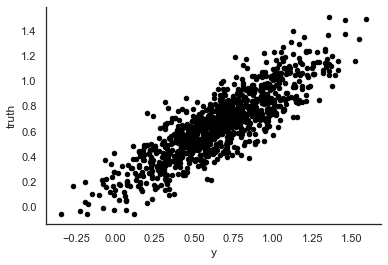

In [4]:
# Generate data
# Generate the fixed effects features X and f(X)
# Doc: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html
if (f_structure == "friedman1"):
    # Out of the n_features features, only 5 are actually used to compute y.
    # The remaining features are independent of y.
    X, f_X = make_friedman1(n_samples=n, n_features=10, noise=0.0, random_state=random_seed)
elif (f_structure == "friedman3"):
    X, f_X = make_friedman3(n_samples=n, noise=0.0, random_state=random_seed)

# Simulate random effects and therefore the response variable y
X, y, truth, Zu = make_sim(X, f_X, n_categories, sig2noise, y_dist, inverse_link, cat_dist, random_seed)

# Plot y truth (i.e. the conditional mean) against y observed
# The smaller the noise component, the closer the points follow a straight line
_ = pd.DataFrame({"y": y[:1000], "truth": truth[:1000]}).plot.scatter(x="y", y="truth", color="black")

In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = split(X, y, n_train)

# Conditional mean true values (unobservable in practice)
y_true_train = truth[:n_train]
y_true_test = truth[n_train:]

In [6]:
X_train.shape, X_test.shape

((5000, 11), (2500, 11))

In [7]:
# Combine X, y, and truth into a dataframe and save to files
train_data = pd.concat([
    X_train.reset_index(drop=True), 
    pd.DataFrame(y_train, columns=["y"]), 
    pd.DataFrame(y_true_train, columns=["y_true"])], axis=1)
test_data = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(y_test, columns=["y"]),
    pd.DataFrame(y_true_test, columns=["y_true"])], axis=1)

path = f"data/experiment_{exp_id}"
train_data.to_csv(f"{path}/train_data.csv", index=False)
test_data.to_csv(f"{path}/test_data.csv", index=False)

In [8]:
# Print summary statistics of the data
hicard_var = "category"
x_num = [col for col in X.columns if col not in hicard_var]
X[x_num].describe().transpose()

count      mean       std       min       25%       50%       75%  \
X1   7500.0  0.497615  0.288852  0.000125  0.248998  0.496073  0.749031   
X2   7500.0  0.494521  0.288870  0.000017  0.241848  0.494511  0.742734   
X3   7500.0  0.501841  0.287485  0.000012  0.251606  0.501669  0.749772   
X4   7500.0  0.499331  0.288483  0.000008  0.249689  0.500278  0.748632   
X5   7500.0  0.500825  0.288590  0.000135  0.252035  0.502506  0.753344   
X6   7500.0  0.506034  0.289164  0.000047  0.258761  0.505642  0.761703   
X7   7500.0  0.501282  0.285492  0.000006  0.254993  0.501586  0.744931   
X8   7500.0  0.496218  0.288666  0.000053  0.248826  0.494834  0.748937   
X9   7500.0  0.501712  0.287811  0.000110  0.251896  0.502645  0.750863   
X10  7500.0  0.498679  0.287630  0.000270  0.249869  0.498534  0.746239   

          max  
X1   0.999805  
X2   0.999789  
X3   0.999957  
X4   0.999901  
X5   0.999841  
X6   0.999875  
X7   0.999972  
X8   0.999824  
X9   0.999925  
X10  0.999786

In [9]:
pd.DataFrame(y).describe().transpose()

count      mean       std       min       25%       50%       75%  \
0  7500.0  0.657592  0.323488 -0.518781  0.434136  0.658003  0.881773   

        max  
0  1.746482

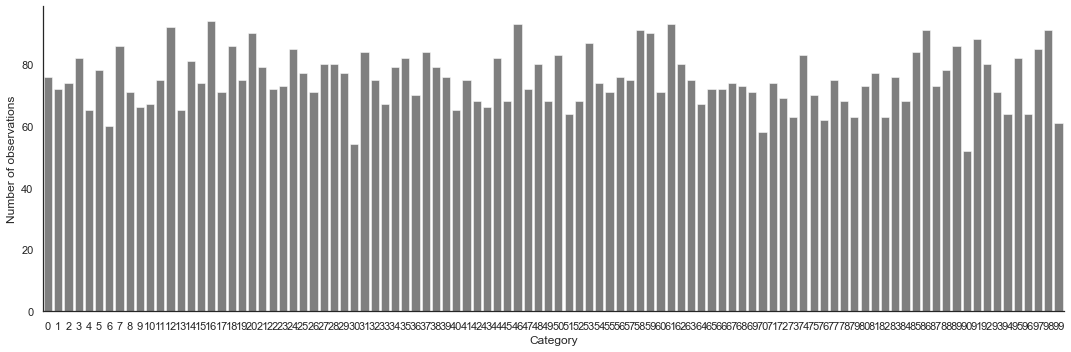

In [10]:
cat_count = X[hicard_var].value_counts()
fig = plt.figure(figsize=(15, 5))
_ = sns.barplot(x=cat_count.index, y=cat_count.values, color="black", alpha=0.5)
plt.ylabel("Number of observations")
plt.xlabel("Category")
plt.tight_layout()

#### GLM

In [11]:
ignore_cat_encoder = make_column_transformer(
    ("drop", [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
GLM_ignore_cat = make_pipeline(ignore_cat_encoder, LinearRegression())
# Apply the pipeline to the dataframe for prediction
GLM_ignore_cat.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('linearregression', LinearRegression())])

In [12]:
train_scores = dict()
test_scores = dict()

print("> In-sample performance")
train_scores["GLM_ignore_cat"] = evaluate_model(GLM_ignore_cat, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GLM_ignore_cat"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GLM_ignore_cat"] = evaluate_model(GLM_ignore_cat, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GLM_ignore_cat"])

> In-sample performance
{'CRPS': 0.14310900069846105,
 'MAE': 0.20262877204739305,
 'MedAE': 0.16936067787763598,
 'MedPE': 0.24174006647096186,
 'NLL': 0.048874104326739144,
 'R2': 0.3799743159135275,
 'RMSE': 0.2540905882539191,
 'RMSE_avg': 0.15385731178238027,
 'RMSE_avg_weighted': 0.15326304978025115}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.14272557899715393,
 'MAE': 0.2016853331178287,
 'MedAE': 0.1677761073170412,
 'MedPE': 0.24126061659871767,
 'NLL': 0.04484974105461321,
 'R2': 0.3931008214973465,
 'RMSE': 0.25307009022743493,
 'RMSE_avg': 0.16212135260176963,
 'RMSE_avg_weighted': 0.16319322865230174}


In [13]:
p = plot_from_model(GLM_ignore_cat, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)

Observe that errors are quite large w.r.t. the distribution of the response variable. The model does not appear to overfit.

In [14]:
one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", drop="first"), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
GLM_one_hot = make_pipeline(one_hot_encoder, LinearRegression())
GLM_one_hot.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('linearregression', LinearRegression())])

In [15]:
print("> In-sample performance")
train_scores["GLM_one_hot"] = evaluate_model(GLM_one_hot, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GLM_one_hot"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GLM_one_hot"] = evaluate_model(GLM_one_hot, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GLM_one_hot"])

> In-sample performance
{'CRPS': 0.11416816856294194,
 'MAE': 0.16139807514282584,
 'MedAE': 0.13662306707797053,
 'MedPE': 0.19826416493588334,
 'NLL': -0.17770528927772133,
 'R2': 0.6059010121589711,
 'RMSE': 0.20257525689624756,
 'RMSE_avg': 9.937147130028223e-07,
 'RMSE_avg_weighted': 9.332011506174265e-07}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.1123245565498542,
 'MAE': 0.15872510471813694,
 'MedAE': 0.13316205724681376,
 'MedPE': 0.1901643331680208,
 'NLL': -0.19154578461882665,
 'R2': 0.6217438438442859,
 'RMSE': 0.19979082838036155,
 'RMSE_avg': 0.050725327017840674,
 'RMSE_avg_weighted': 0.04982970432760635}


In [16]:
p = plot_from_model(GLM_one_hot, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)

In [17]:
# Apply a cross-validated version of GLMM encoding
GLMM_encoder = make_column_transformer(
    # https://contrib.scikit-learn.org/category_encoders/wrapper.html
    (NestedCVWrapper(ce.glmm.GLMMEncoder(), cv=KFold(n_splits=5)), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
GLM_GLMM_enc = make_pipeline(GLMM_encoder, LinearRegression())
GLM_GLMM_enc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nestedcvwrapper',
                                                  NestedCVWrapper(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                                                                  feature_encoder=GLMMEncoder()),
                                                  ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('linearregression', LinearRegression())])

In [18]:
# Check how the GLMMencoder works
# Docs: https://contrib.scikit-learn.org/category_encoders/_modules/category_encoders/wrapper.html#NestedCVWrapper.transform
# https://contrib.scikit-learn.org/category_encoders/_modules/category_encoders/glmm.html#GLMMEncoder
GLMM_encodings = pd.DataFrame({
    "category": X_train[hicard_var].values,
    "encoding": NestedCVWrapper(ce.GLMMEncoder(), cv=KFold(n_splits=5)).fit_transform(X_train["category"], y_train).values.ravel(),
})
GLMM_encodings

category  encoding
0          51  0.340667
1          92 -0.002120
2          14  0.234305
3          71 -0.032545
4          60 -0.132732
...       ...       ...
4995       48 -0.150653
4996       57  0.058180
4997       38 -0.122347
4998       79 -0.027919
4999       96 -0.162064

[5000 rows x 2 columns]

In [19]:
# Different values for different folds (on the training set)
GLMM_encodings[GLMM_encodings["category"] == 51].value_counts()

category  encoding
51        0.265839    12
          0.340667    12
          0.316554     7
          0.273471     6
          0.280705     5
dtype: int64

In [20]:
# Plot GLMM encodings vs true random effects
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Encodings", width=400, height=400)
p.add_layout(bom.Title(text="Model: GLMM encodings", text_font_style="italic"), "above")
GLMM_encodings = GLMM_encoder.named_transformers_["nestedcvwrapper"].transform(X_train[hicard_var])
p.circle(Zu[:n_train], GLMM_encodings.values.ravel(), color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

The linear shape of the plot above suggests that the GLMM encodings were able to capture the random effects very well - as one would expect given that the random effects signal is reasonably strong.

In [21]:
print("> In-sample performance")
train_scores["GLM_GLMM_enc"] = evaluate_model(GLM_GLMM_enc, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GLM_GLMM_enc"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GLM_GLMM_enc"] = evaluate_model(GLM_GLMM_enc, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GLM_GLMM_enc"])

> In-sample performance
{'CRPS': 0.11534203442830271,
 'MAE': 0.1633558920515475,
 'MedAE': 0.13756463694523974,
 'MedPE': 0.201515837825817,
 'NLL': -0.16709453476883912,
 'R2': 0.5974482641242197,
 'RMSE': 0.20473617744099532,
 'RMSE_avg': 0.030397940842192234,
 'RMSE_avg_weighted': 0.02962025935107252}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.11397651502660888,
 'MAE': 0.161099899041167,
 'MedAE': 0.13783489081702643,
 'MedPE': 0.19518101079580505,
 'NLL': -0.1782191517351888,
 'R2': 0.6115265243757837,
 'RMSE': 0.20247118781780296,
 'RMSE_avg': 0.06045183469225832,
 'RMSE_avg_weighted': 0.05976245049744218}


In [22]:
p = plot_from_model(GLM_GLMM_enc, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)

We don't observe much improvement over the one-hot encoded model, most likely due to the restrictive structure of GLM in modelling the highly nonlinear relationship in `friedman1` data.

#### GBM

In [23]:
GBM = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_seed)
GBM_ignore_cat = make_pipeline(ignore_cat_encoder, GBM)
GBM_ignore_cat.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              ena...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=2, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
                              predictor='auto', random_state=42, reg_alpha=0,
                              reg_lambda=1, ...))])

In [24]:
print("> In-sample performance")
train_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_ignore_cat"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GBM_ignore_cat"])

> In-sample performance
{'CRPS': 0.1281124350846384,
 'MAE': 0.18075567940160472,
 'MedAE': 0.15133750876617064,
 'MedPE': 0.21501249750919713,
 'NLL': -0.06082665959372253,
 'R2': 0.5021198550405592,
 'RMSE': 0.22769114562822929,
 'RMSE_avg': 0.148274240164422,
 'RMSE_avg_weighted': 0.14779537393633335}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.13243269293283091,
 'MAE': 0.18759429956744747,
 'MedAE': 0.15912884162957902,
 'MedPE': 0.2242994334501887,
 'NLL': -0.03154899347579817,
 'R2': 0.4790962883487093,
 'RMSE': 0.23445595669197514,
 'RMSE_avg': 0.16034502481725862,
 'RMSE_avg_weighted': 0.1609900727892125}


Again, errors are quite large w.r.t. the distribution of the response variable.

In order to prevent overfitting, the default hyperparameters have been adjusted such that the training and validation results are comparable. No extensive/systematic hyperparameter search has been performed.

In [25]:
p = plot_from_model(GBM_ignore_cat, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)

In [26]:
GBM_one_hot = make_pipeline(one_hot_encoder, GBM)
GBM_one_hot.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_byno...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=2, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
                              predictor='auto', random_state=42, reg_alpha=0,
                              reg_lambda=1, ...))])

In [27]:
print("> In-sample performance")
train_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_one_hot"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GBM_one_hot"])

> In-sample performance
{'CRPS': 0.12065506502236965,
 'MAE': 0.17100201169366364,
 'MedAE': 0.14314922729304175,
 'MedPE': 0.2031975439357439,
 'NLL': -0.12420714707816233,
 'R2': 0.5613953664588784,
 'RMSE': 0.21370778659502337,
 'RMSE_avg': 0.11617693861093174,
 'RMSE_avg_weighted': 0.1145791590987619}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.12491198511560449,
 'MAE': 0.17786349042267252,
 'MedAE': 0.15320779735139545,
 'MedPE': 0.21709161123367943,
 'NLL': -0.09350984308994433,
 'R2': 0.539808130118387,
 'RMSE': 0.22036976879361492,
 'RMSE_avg': 0.129886008722333,
 'RMSE_avg_weighted': 0.13091323292442444}


In [28]:
p = plot_from_model(GBM_one_hot, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)

The high validation error with `GBM_one_hot` is likely due to the model overfitting to the large number of categories. Tree-based models are known to be tricked by such variables.

In [29]:
# Apply a cross-validated version of GLMM encoding
GBM_GLMM_enc = make_pipeline(GLMM_encoder, GBM)
GBM_GLMM_enc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nestedcvwrapper',
                                                  NestedCVWrapper(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                                                                  feature_encoder=GLMMEncoder()),
                                                  ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree'...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=2, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
                              predictor='auto', random_state=42, reg_alpha=0,
                              reg_lambda=1, ...))])

In [30]:
print("> In-sample performance")
train_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_GLMM_enc"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GBM_GLMM_enc"])

> In-sample performance
{'CRPS': 0.09979870388519771,
 'MAE': 0.14124056067854698,
 'MedAE': 0.11830239524650843,
 'MedPE': 0.1704138480999885,
 'NLL': -0.31125734429389423,
 'R2': 0.6982804311876434,
 'RMSE': 0.17724968734391958,
 'RMSE_avg': 0.03401761319913957,
 'RMSE_avg_weighted': 0.03375052499121346}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.10231475798287837,
 'MAE': 0.14523208102136898,
 'MedAE': 0.12317272986804373,
 'MedPE': 0.17640773873178198,
 'NLL': -0.28766162279517155,
 'R2': 0.6878949120204665,
 'RMSE': 0.18148175459097324,
 'RMSE_avg': 0.058676416751631474,
 'RMSE_avg_weighted': 0.059086801016106}


In [31]:
p = plot_from_model(GBM_GLMM_enc, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)

#### NN with Entity Embeddings

In [32]:
# Preprocess the data
ct_nn = make_column_transformer(
    (ce.ordinal.OrdinalEncoder(handle_unknown="value"), [hicard_var]), # "value" encodes unknown categories as "-1"
    (MinMaxScaler(feature_range=(0, 1)), x_num),
)
X_train_ct = ct_nn.fit_transform(X_train)
X_test_ct = ct_nn.transform(X_test)

# Convert to dataframes
colnames = [hicard_var] + x_num
X_train_ct = pd.DataFrame(X_train_ct, columns=colnames)
X_test_ct = pd.DataFrame(X_test_ct, columns=colnames)

# Convert dataframe to lists to feed into Keras model
X_embed_train, X_embed_test = embedding_preproc(X_train_ct, X_test_ct, [hicard_var])

[category] cardinality: 100 and embedding dim: 3
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



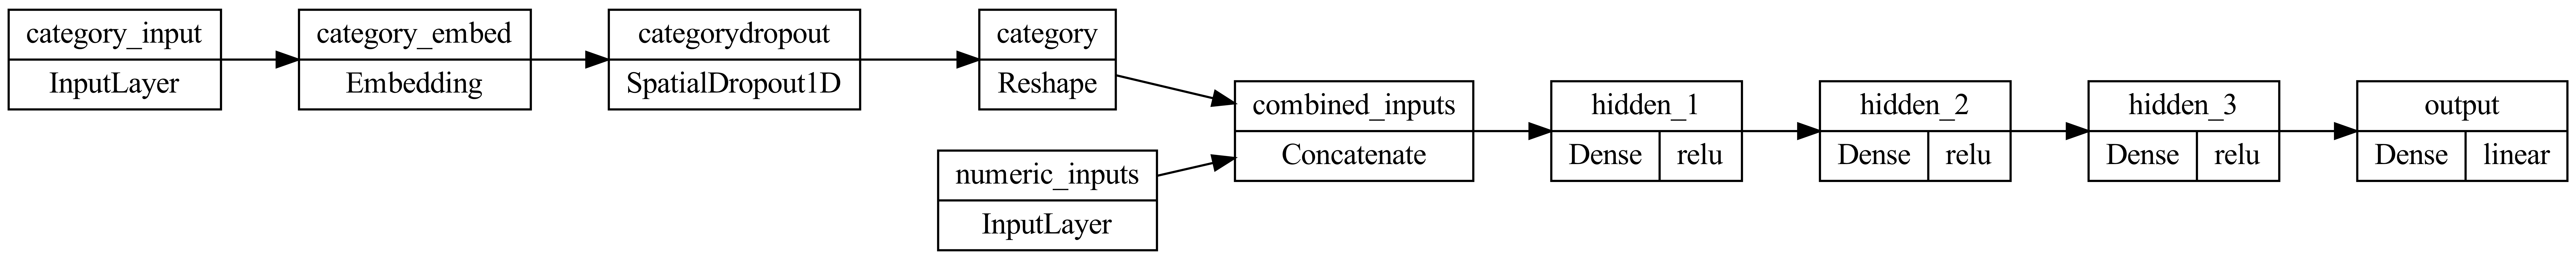

In [33]:
NN_ee = build_baseline_nn(X_train_ct, print_embeddings=True, random_state=random_seed, cat_vars=[hicard_var], num_vars=x_num)
plot_model(NN_ee, dpi=600, show_layer_activations=True, rankdir="LR")

In [34]:
NN_ee.count_params()

3821

In [35]:
# Define training parameters
epochs = 500
patience = 50
batch_size = 256
es = EarlyStopping(patience=patience, restore_best_weights=True, monitor="val_loss", verbose=2)

NN_ee = build_baseline_nn(X_train_ct, random_state=random_seed, num_vars=x_num, cat_vars=[hicard_var])
hist = NN_ee.fit(
    (tuple(X_embed_train), X_train_ct[x_num]), y_train, validation_split=0.2, 
    epochs=epochs, callbacks=[es], batch_size=batch_size, verbose=0)
hist = hist.history

y_pred_train = NN_ee.predict((tuple(X_embed_train), X_train_ct[x_num])).flatten()
y_pred_test = NN_ee.predict((tuple(X_embed_test), X_test_ct[x_num])).flatten()

2023-01-25 00:08:03.254097: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Restoring model weights from the end of the best epoch: 100.
Epoch 150: early stopping
79/79 [==============================] - 0s 3ms/step


In [36]:
print("> In-sample performance")
train_scores["NN_ee"] = evaluate_predictions(y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["NN_ee"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["NN_ee"] = evaluate_predictions(y_test, y_pred_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["NN_ee"])

> In-sample performance
{'CRPS': 0.09319684490604081,
 'MAE': 0.13082934607313426,
 'MedAE': 0.10907266550804742,
 'MedPE': 0.15876337661554846,
 'NLL': -0.3781472407382247,
 'R2': 0.7360609479629796,
 'RMSE': 0.16578130914924907,
 'RMSE_avg': 0.03138387531713449,
 'RMSE_avg_weighted': 0.030656822544077072}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.1012411207390618,
 'MAE': 0.14232159056971835,
 'MedAE': 0.11777668016167389,
 'MedPE': 0.17298730061079404,
 'NLL': -0.2949598186564184,
 'R2': 0.6924174335998562,
 'RMSE': 0.18016208665578082,
 'RMSE_avg': 0.05775976846101177,
 'RMSE_avg_weighted': 0.055471676400867205}


In [37]:
p = plot_from_predictions(
    y_pred_train=y_pred_train,
    y_train=y_true_train,
    y_pred_test=y_pred_test,
    y_test=y_true_test,
    log_scale=log_plot,
)

In [38]:
# Extract embeddings from the fitted neural network model
embeddings = NN_ee.get_layer(f"{hicard_var}_embed").get_weights()[0]
embeddings = pd.DataFrame(embeddings, columns=["embedding_" + str(i) for i in range(embeddings.shape[1])])
oe = ct_nn.named_transformers_["ordinalencoder"]
categories = np.array(oe.category_mapping[0]["mapping"])[:-1]
embeddings = pd.concat([pd.DataFrame(categories, columns=[hicard_var]), embeddings], axis=1)
embeddings

category  embedding_0  embedding_1  embedding_2
0          1     0.048957     0.016420     0.000377
1          2    -0.151543     0.151338     0.107844
2          3     0.017067     0.014004     0.024592
3          4    -0.141426     0.091806     0.121387
4          5    -0.035154    -0.016515    -0.017534
..       ...          ...          ...          ...
95        96     0.086757    -0.025675    -0.089864
96        97     0.041059     0.013503    -0.018339
97        98    -0.082859     0.111140     0.117976
98        99     0.017006    -0.019222     0.003259
99       100    -0.092645     0.159033     0.072147

[100 rows x 4 columns]

#### GBM with Entity Embeddings

In [39]:
X_train_ee = pd.merge(X_train_ct, embeddings, on="category", how="left").drop("category", axis=1)
X_test_ee = pd.merge(X_test_ct, embeddings, on="category", how="left").drop("category", axis=1)

In [40]:
GBM_ee = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_seed)
GBM_ee.fit(X_train_ee, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [41]:
print("> In-sample performance")
train_scores["GBM_ee"] = evaluate_model(GBM_ee, X_train_ee, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_ee"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GBM_ee"] = evaluate_model(GBM_ee, X_test_ee, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GBM_ee"])

> In-sample performance
{'CRPS': 0.11836641636490285,
 'MAE': 0.16725980698212822,
 'MedAE': 0.14084720426341718,
 'MedPE': 0.19903007638971515,
 'NLL': -0.13967203242891618,
 'R2': 0.5747536578402903,
 'RMSE': 0.2104282444104589,
 'RMSE_avg': 0.11570788800479528,
 'RMSE_avg_weighted': 0.1142160918184507}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.12195812963660034,
 'MAE': 0.17304426906568707,
 'MedAE': 0.14854340276448663,
 'MedPE': 0.2080206682439118,
 'NLL': -0.11399931447712888,
 'R2': 0.5582851367308693,
 'RMSE': 0.21590045204748323,
 'RMSE_avg': 0.12877518103414634,
 'RMSE_avg_weighted': 0.1292631744309345}


In [42]:
p = plot_from_model(GBM_ee, X_train_ee, y_true_train, X_test_ee, y_true_test, log_scale=log_plot)

#### (Generalised) Linear Mixed Effects Models

In [43]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


In [44]:
y_pred_train_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_pred_train.csv").values.reshape(-1)
y_pred_test_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_pred_test.csv").values.reshape(-1)
re_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_re.csv").values.reshape(-1)
sigma_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_sigma.csv").values.reshape(-1)

In [45]:
# Evaluate model performance
# Training set
print("> In-sample performance")
train_scores["GLMM"] = evaluate_predictions(
    y_train, y_pred_train_brms, categories=X_train[hicard_var], likelihood=y_dist,
    loc=y_pred_train_brms, scale=sigma_brms,
)
pp.pprint(train_scores["GLMM"])

# Validation set
print("-" * 80)
print("> Out-of-sample performance")
test_scores["GLMM"] = evaluate_predictions(
    y_test, y_pred_test_brms, categories=X_test[hicard_var], likelihood=y_dist,
    loc=y_pred_test_brms, scale=sigma_brms,
)
pp.pprint(test_scores["GLMM"])

> In-sample performance
{'CRPS': 0.11414328802029863,
 'MAE': 0.16139467722563117,
 'MedAE': 0.1360819913623484,
 'MedPE': 0.19750830458236235,
 'NLL': -0.1778699020502446,
 'R2': 0.6061312128600006,
 'RMSE': 0.20251608422722592,
 'RMSE_avg': 0.005710983146475842,
 'RMSE_avg_weighted': 0.0055383640325953444}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.11242150629680006,
 'MAE': 0.15881534277526801,
 'MedAE': 0.13272944792169422,
 'MedPE': 0.19011166975197608,
 'NLL': -0.19042070911821218,
 'R2': 0.6213335594131721,
 'RMSE': 0.19989915292328841,
 'RMSE_avg': 0.051170879882879605,
 'RMSE_avg_weighted': 0.0505267609012017}


In [46]:
p = plot_from_predictions(y_pred_train_brms, y_true_train, y_pred_test_brms, y_true_test, log_scale=log_plot)

In [47]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
p.add_layout(bom.Title(text="Model: GLMM", text_font_style="italic"), "above")
rev = np.array([float(re_brms[g]) for g in X_train[hicard_var]])
p.circle(Zu[:n_train], rev, color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

#### GPBoost
There's also a Python library for GPBoost. Installation worked but I kept getting errors from any attempt to call a function from the package. The temporary workaround therefore is to use the R package and read in the predictions.

In [48]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


In [49]:
y_pred_train_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_pred_train.csv").values.reshape(-1)
y_pred_test_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_pred_test.csv").values.reshape(-1)
re_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_re.csv").values.reshape(-1)
scale_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_scale.csv").values.reshape(-1)

In [50]:
# Evaluate model performance
# Training set
print("> In-sample performance")
train_scores["GPBoost"] = evaluate_predictions(
    y_train, y_pred_train_gpb, categories=X_train[hicard_var], likelihood=y_dist,
    loc=y_pred_train_gpb, scale=np.sqrt(scale_gpb),
)
pp.pprint(train_scores["GPBoost"])

# Validation set
print("-" * 80)
print("> Out-of-sample performance")
test_scores["GPBoost"] = evaluate_predictions(
    y_test, y_pred_test_gpb, categories=X_test[hicard_var], likelihood=y_dist,
    loc=y_pred_test_gpb, scale=np.sqrt(scale_gpb),
)
pp.pprint(test_scores["GPBoost"])

> In-sample performance
{'CRPS': 0.10897228971926635,
 'MAE': 0.15416212242919664,
 'MedAE': 0.13071627853944984,
 'MedPE': 0.18897401959535437,
 'NLL': -0.2242019798745941,
 'R2': 0.6409279921394511,
 'RMSE': 0.19336350677633904,
 'RMSE_avg': 0.004976766741781084,
 'RMSE_avg_weighted': 0.00484973692481012}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.11331694146361308,
 'MAE': 0.15990417212872496,
 'MedAE': 0.13447217945194545,
 'MedPE': 0.19871698086501186,
 'NLL': -0.18379879636401628,
 'R2': 0.6174308009739478,
 'RMSE': 0.200926651169445,
 'RMSE_avg': 0.050962464817209514,
 'RMSE_avg_weighted': 0.050676318912964764}


In [51]:
p = plot_from_predictions(y_pred_train_gpb, y_true_train, y_pred_test_gpb, y_true_test, log_scale=log_plot)

In [52]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
p.add_layout(bom.Title(text="Model: GPBoost", text_font_style="italic"), "above")
p.circle(Zu[:n_train], re_gpb, color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

#### GLMMNet

In [53]:
one_hot = ce.OneHotEncoder(cols=[hicard_var], handle_unknown="value")
X_train_ct_ohe = one_hot.fit_transform(X_train_ct)
X_test_ct_ohe = one_hot.transform(X_test_ct)
cardinality = len(one_hot.category_mapping[0]["mapping"].keys()) - 1

In [54]:
epochs = 500
patience = 50
batch_size = 256
n_prediction_samples = 100

glmmnet = build_glmmnet(
    cardinality=cardinality, num_vars=x_num, final_layer_likelihood=y_dist, 
    train_size=X_train.shape[0], random_state=random_seed)
es = EarlyStopping(patience=patience, restore_best_weights=True, monitor="val_loss", verbose=0)
hist = glmmnet.fit(
    (X_train_ct.drop([hicard_var], axis=1), X_train_ct_ohe.loc[:, X_train_ct_ohe.columns.str.startswith(hicard_var)]), y_train, 
    validation_split=0.2, callbacks=[es], batch_size=batch_size, epochs=epochs, verbose=False)
hist = hist.history

y_pred_train = predict_glmmnet(glmmnet, X_train_ct_ohe, hicard_var, n_prediction_samples)
y_pred_test = predict_glmmnet(glmmnet, X_test_ct_ohe, hicard_var, n_prediction_samples)
phi = glmmnet.get_layer("dist_params").get_weights()

100%|██████████| 100/100 [00:02<00:00, 34.13it/s]


In [55]:
plot_loss_curves(hist)

Figure(id='5246', ...)

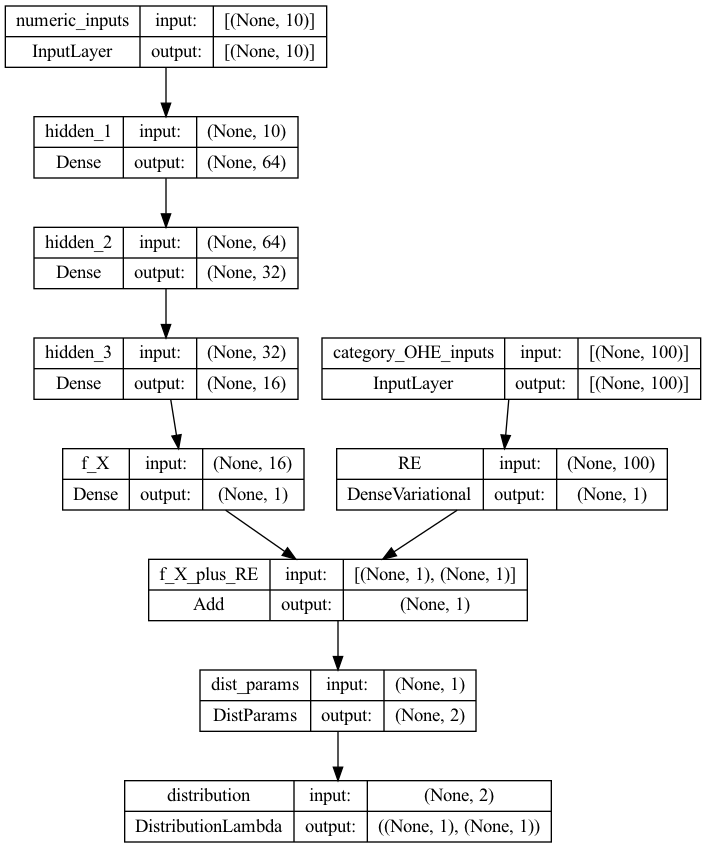

In [56]:
plot_model(glmmnet, show_shapes=True, show_layer_names=True)

In [57]:
# Examine the trained parameters
dummy_input = tf.constant(0.) # doesn't matter what this is
model_prior = glmmnet.get_layer("RE")._prior(dummy_input)
model_posterior = glmmnet.get_layer("RE")._posterior(dummy_input)

print("Prior mean:     ", model_prior.mean().numpy()[0])
print("Prior variance: ", model_prior.variance().numpy()[0])
print("Posterior mean: ")
print(model_posterior.mean().numpy())
print("Posterior variance: " )
print(model_posterior.variance().numpy())

# Get the dispersion parameter (here the error variance)
print(f"Estimated sigma_e: {phi[0][0]:.8f}")

Prior mean:      0.0
Prior variance:  0.010000001
Posterior mean: 
[ 0.2659978  -0.00471287  0.23001575 -0.03193578 -0.18340236 -0.04453418
  0.22477484  0.06766292  0.12897354  0.19686234 -0.06214064 -0.07830117
  0.27314135 -0.11131991 -0.1864848   0.01601246 -0.04373469  0.14962116
 -0.0899113   0.13938937  0.1784924   0.0924833   0.04562645 -0.02005241
 -0.16611381  0.10599772 -0.04489923  0.22027692 -0.08875459 -0.04531948
  0.16644192 -0.05530687  0.18281132 -0.1042406  -0.09964655  0.05631811
 -0.15214185  0.23581949  0.02126303 -0.12099214  0.15060663 -0.20879926
 -0.09058895  0.07520466 -0.147283   -0.24362274 -0.02893635  0.37071577
 -0.01911596 -0.00475035 -0.18301338 -0.1313816   0.19344392  0.00319728
 -0.22352563 -0.12922628  0.01196618 -0.06960876 -0.13420935  0.06457414
  0.09652723  0.09368607 -0.23628744  0.05561239 -0.0723785  -0.07814312
 -0.01165582  0.03253311 -0.10501978  0.02717137 -0.12723361 -0.10088047
  0.06012581  0.13704671  0.02849874  0.12414604 -0.09947

In [58]:
p = plot_from_predictions(y_pred_train, y_true_train, y_pred_test, y_true_test, log_scale=log_plot)

In [59]:
# Evaluate model performance
# Training set
print("> In-sample performance")
train_scores["GLMMNet"] = evaluate_predictions(
    y_train, y_pred_train, categories=X_train[hicard_var], 
    likelihood=y_dist, loc=y_pred_train, scale=phi[0][0]
)
pp.pprint(train_scores["GLMMNet"])

# Validation set
print("-" * 80)
print("> Out-of-sample performance")
test_scores["GLMMNet"] = evaluate_predictions(
    y_test, y_pred_test, categories=X_test[hicard_var], likelihood=y_dist,
    loc=y_pred_test, scale=phi[0][0]
)
pp.pprint(test_scores["GLMMNet"])

> In-sample performance
{'CRPS': 0.09638380233123729,
 'MAE': 0.1359473292154453,
 'MedAE': 0.11121774612905372,
 'MedPE': 0.16800294851652559,
 'NLL': -0.3468367400125026,
 'R2': 0.7190221862745426,
 'RMSE': 0.1710486902526828,
 'RMSE_avg': 0.01850893296270491,
 'RMSE_avg_weighted': 0.01864966048228546}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.09924241666261434,
 'MAE': 0.140508554994945,
 'MedAE': 0.1201757711397765,
 'MedPE': 0.17825664999595395,
 'NLL': -0.3188596121699533,
 'R2': 0.7070587503968143,
 'RMSE': 0.17582183567455334,
 'RMSE_avg': 0.0450507391876395,
 'RMSE_avg_weighted': 0.04501576449154251}


In [60]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
p.add_layout(bom.Title(text="Model: GLMMNet", text_font_style="italic"), "above")
# Get the posterior mean of the random effects
u_hat = glmmnet.get_layer("RE").weights[0][:cardinality]
re_glmmnet = tf.gather(u_hat, X_train_ct[hicard_var].astype("int") - 1).numpy() # minus 1 because the categories are 1-indexed
p.circle(Zu[:n_train], re_glmmnet, color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

79/79 [==============================] - 0s 3ms/step


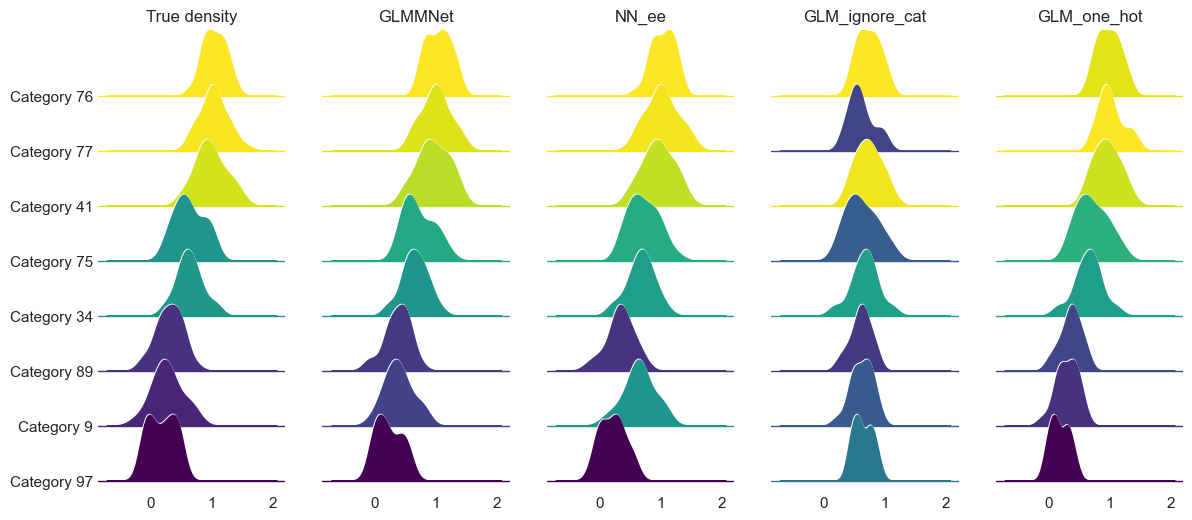

In [61]:
# Code adapted from https://scipython.com/blog/ridgeline-plots-of-monthly-uk-temperatures/
dpi = 100
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(1400/dpi, 600/dpi), dpi=dpi)

ranked_cats = test_data.groupby("category").mean().sort_values("y").index.to_list()
selected_cats = ranked_cats[:3] + ranked_cats[len(ranked_cats)//2:len(ranked_cats)//2+2] + ranked_cats[-3:]
p_min, p_max = y_true_test.min(), y_true_test.max()
plot_ridgeline(X_test["category"], y_true_test, selected_cats, axes[0], "True density")
plot_ridgeline(X_test["category"], y_pred_test, selected_cats, axes[1], "GLMMNet", ylabel=False, p_min=p_min, p_max=p_max)
NN_ee_y_pred_test = NN_ee.predict((tuple(X_embed_test), X_test_ct[x_num])).flatten()
plot_ridgeline(X_test["category"], NN_ee_y_pred_test, selected_cats, axes[2], "NN_ee", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GLM_ignore_cat.predict(X_test), selected_cats, axes[3], "GLM_ignore_cat", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GLM_one_hot.predict(X_test), selected_cats, axes[4], "GLM_one_hot", ylabel=False, p_min=p_min, p_max=p_max)

plt.show()
# fig.savefig(f"figures/experiment_{exp_id}/ridgeline.pdf")

#### Comparison of Models for Experiment #1

In [62]:
with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())
    display(pd.DataFrame(test_scores).transpose())

MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat 0.2026 0.1694 0.2417 0.2541 0.3800    0.1539   
GLM_one_hot    0.1614 0.1366 0.1983 0.2026 0.6059    0.0000   
GLM_GLMM_enc   0.1634 0.1376 0.2015 0.2047 0.5974    0.0304   
GBM_ignore_cat 0.1808 0.1513 0.2150 0.2277 0.5021    0.1483   
GBM_one_hot    0.1710 0.1431 0.2032 0.2137 0.5614    0.1162   
GBM_GLMM_enc   0.1412 0.1183 0.1704 0.1772 0.6983    0.0340   
NN_ee          0.1308 0.1091 0.1588 0.1658 0.7361    0.0314   
GBM_ee         0.1673 0.1408 0.1990 0.2104 0.5748    0.1157   
GLMM           0.1614 0.1361 0.1975 0.2025 0.6061    0.0057   
GPBoost        0.1542 0.1307 0.1890 0.1934 0.6409    0.0050   
GLMMNet        0.1359 0.1112 0.1680 0.1710 0.7190    0.0185   

                RMSE_avg_weighted   CRPS     NLL  
GLM_ignore_cat             0.1533 0.1431  0.0489  
GLM_one_hot                0.0000 0.1142 -0.1777  
GLM_GLMM_enc               0.0296 0.1153 -0.1671  
GBM_ignore_cat             0.1478 0.1281 -0.0608  
GBM_one_hot                0.1146 0.1207 -0.1242  
GBM_GLMM_enc               0.0338 0.0998 -0.3113  
NN_ee                      0.0307 0.0932 -0.3781  
GBM_ee                     0.1142 0.1184 -0.1397  
GLMM                       0.0055 0.1141 -0.1779  
GPBoost                    0.0048 0.1090 -0.2242  
GLMMNet                    0.0186 0.0964 -0.3468

MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat 0.2017 0.1678 0.2413 0.2531 0.3931    0.1621   
GLM_one_hot    0.1587 0.1332 0.1902 0.1998 0.6217    0.0507   
GLM_GLMM_enc   0.1611 0.1378 0.1952 0.2025 0.6115    0.0605   
GBM_ignore_cat 0.1876 0.1591 0.2243 0.2345 0.4791    0.1603   
GBM_one_hot    0.1779 0.1532 0.2171 0.2204 0.5398    0.1299   
GBM_GLMM_enc   0.1452 0.1232 0.1764 0.1815 0.6879    0.0587   
NN_ee          0.1423 0.1178 0.1730 0.1802 0.6924    0.0578   
GBM_ee         0.1730 0.1485 0.2080 0.2159 0.5583    0.1288   
GLMM           0.1588 0.1327 0.1901 0.1999 0.6213    0.0512   
GPBoost        0.1599 0.1345 0.1987 0.2009 0.6174    0.0510   
GLMMNet        0.1405 0.1202 0.1783 0.1758 0.7071    0.0451   

                RMSE_avg_weighted   CRPS     NLL  
GLM_ignore_cat             0.1632 0.1427  0.0448  
GLM_one_hot                0.0498 0.1123 -0.1915  
GLM_GLMM_enc               0.0598 0.1140 -0.1782  
GBM_ignore_cat             0.1610 0.1324 -0.0315  
GBM_one_hot                0.1309 0.1249 -0.0935  
GBM_GLMM_enc               0.0591 0.1023 -0.2877  
NN_ee                      0.0555 0.1012 -0.2950  
GBM_ee                     0.1293 0.1220 -0.1140  
GLMM                       0.0505 0.1124 -0.1904  
GPBoost                    0.0507 0.1133 -0.1838  
GLMMNet                    0.0450 0.0992 -0.3189

### Experiment #2

In [63]:
# Configure simulation parameters
exp_id = 2                         # experiment id
sig2noise = np.array([4, 1, 1])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gamma"                   # distribution of the response variable y
inverse_link = np.exp              # inverse of the log link
cat_dist = "balanced"              # distribution of the categorical variable
random_seed = 42 + 4               # random seed for reproducibility
log_plot = True                    # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network (entity embedding model)

In [64]:
# Generate data
sim_data = generate_data(
    exp_id=exp_id, n_train=n_train, n_test=n_test, n_categories=n_categories,
    f_structure=f_structure, signal_to_noise=sig2noise, y_dist=y_dist,
    inverse_link=inverse_link, cat_dist=cat_dist, random_state=random_seed,
    overwrite=True
)

In [65]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


In [66]:
# Make a function to make life easier for repeated experiments
# Skip all the plotting and just return the table of results
def run_sim_experiment(exp_id, sim_data, y_dist="gaussian", random_state=random_seed):

    # Unpack data
    X_train, y_train, y_true_train = sim_data["train"]
    X_test, y_test, y_true_test = sim_data["test"]
    Zu = sim_data["Zu"]

    # Variable names
    hicard_var = "category"
    x_num = [col for col in X_train.columns if col not in hicard_var]
    colnames = [hicard_var] + x_num

    # Convert numeric to string so they can be recognised by ce.OrdinalEncoder
    X_train[hicard_var] = X_train[hicard_var].astype("str")
    X_test[hicard_var] = X_test[hicard_var].astype("str")

    # Initialise
    train_scores = dict()
    test_scores = dict()
    plots = dict()
    runtimes = dict()
    models = dict()

    # GLM
    # -------------------------------------------------------------------------
    ignore_cat_encoder = make_column_transformer(
        ("drop", [hicard_var]),
        (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
    )
    X_train_ic = ignore_cat_encoder.fit_transform(X_train)
    X_test_ic = ignore_cat_encoder.transform(X_test)
    start = time.time()
    if y_dist == "gaussian":
        GLM_ignore_cat = LinearRegression()
        GLM_ignore_cat.fit(X_train_ic, y_train)
        gamma_shape = None # placeholder, will not be read when y_dist == "gaussian"
    elif y_dist == "gamma":
        GLM_ignore_cat = sm.GLM(y_train, X_train_ic, family=sm.families.Gamma(sm.families.links.log())).fit()
        gamma_shape = 1 / GLM_ignore_cat.scale
    end = time.time()
    train_scores["GLM_ignore_cat"] = evaluate_model(
        GLM_ignore_cat, X_train_ic, y_train, categories=X_train[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    test_scores["GLM_ignore_cat"] = evaluate_model(
        GLM_ignore_cat, X_test_ic, y_test, categories=X_test[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    plots["GLM_ignore_cat"] = plot_from_model(GLM_ignore_cat, X_train_ic, y_true_train, X_test_ic, y_true_test, log_scale=log_plot, show=False)
    runtimes["GLM_ignore_cat"] = end - start
    models["GLM_ignore_cat"] = GLM_ignore_cat

    one_hot_encoder = make_column_transformer(
        (OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False), [hicard_var]),
        (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
    )
    X_train_ohe = one_hot_encoder.fit_transform(X_train)
    X_test_ohe = one_hot_encoder.transform(X_test)
    start = time.time()
    if y_dist == "gaussian":
        GLM_one_hot = LinearRegression()
        GLM_one_hot.fit(X_train_ohe, y_train)
        gamma_shape = None # placeholder, will not be read when y_dist == "gaussian"
    elif y_dist == "gamma":
        GLM_one_hot = sm.GLM(y_train, X_train_ohe, family=sm.families.Gamma(sm.families.links.log())).fit()
        gamma_shape = 1 / GLM_one_hot.scale
    end = time.time()
    train_scores["GLM_one_hot"] = evaluate_model(
        GLM_one_hot, X_train_ohe, y_train, categories=X_train[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    test_scores["GLM_one_hot"] = evaluate_model(
        GLM_one_hot, X_test_ohe, y_test, categories=X_test[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    plots["GLM_one_hot"] = plot_from_model(GLM_one_hot, X_train_ohe, y_true_train, X_test_ohe, y_true_test, log_scale=log_plot, show=False)
    runtimes["GLM_one_hot"] = end - start
    models["GLM_one_hot"] = GLM_one_hot

    GLMM_encoder = make_column_transformer(
        # https://contrib.scikit-learn.org/category_encoders/wrapper.html
        (NestedCVWrapper(ce.glmm.GLMMEncoder(), cv=KFold(n_splits=5)), [hicard_var]),
        (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
    )
    X_train_GLMM_enc = GLMM_encoder.fit_transform(X_train, y_train)
    X_test_GLMM_enc = GLMM_encoder.transform(X_test)
    start = time.time()
    if y_dist == "gaussian":
        GLM_GLMM_enc = LinearRegression()
        GLM_GLMM_enc.fit(X_train_GLMM_enc, y_train)
        gamma_shape = None # placeholder, will not be read when y_dist == "gaussian"
    elif y_dist == "gamma":
        GLM_GLMM_enc = sm.GLM(y_train, X_train_GLMM_enc, family=sm.families.Gamma(sm.families.links.log())).fit()
        gamma_shape = 1 / GLM_GLMM_enc.scale
    end = time.time()
    train_scores["GLM_GLMM_enc"] = evaluate_model(
        GLM_GLMM_enc, X_train_GLMM_enc, y_train, categories=X_train[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    test_scores["GLM_GLMM_enc"] = evaluate_model(
        GLM_GLMM_enc, X_test_GLMM_enc, y_test, categories=X_test[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
    plots["GLM_GLMM_enc"] = plot_from_model(GLM_GLMM_enc, X_train_GLMM_enc, y_true_train, X_test_GLMM_enc, y_true_test, log_scale=log_plot, show=False)
    # Plot GLMM encodings vs true random effects
    left, right = Zu.min(), Zu.max()
    span = right - left
    bottom, top = Zu.min() - span * 0.1, Zu.max() + span * 0.1
    p = bop.figure(title="GLMM Encodings", x_axis_label="Ground truth", y_axis_label="GLMM encodings", width=400, height=300,
                   x_range=(left, right), y_range=(bottom, top))
    p.add_layout(bom.Title(text="Model: GLMM encodings", text_font_style="italic"), "above")
    GLMM_encodings = GLMM_encoder.named_transformers_["nestedcvwrapper"].transform(X_train[hicard_var])
    p.circle(Zu[:X_train.shape[0]], GLMM_encodings.values.ravel(), color="#9f86c0")
    p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
    plots["GLMM_encodings"] = p
    runtimes["GLM_GLMM_enc"] = end - start
    models["GLM_GLMM_enc"] = GLM_GLMM_enc

    # GBM
    # -------------------------------------------------------------------------
    GBM_ignore_cat = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_state)
    start = time.time()
    GBM_ignore_cat.fit(X_train_ic, y_train)
    end = time.time()
    train_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_train_ic, y_train, categories=X_train[hicard_var], likelihood=y_dist)
    test_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_test_ic, y_test, categories=X_test[hicard_var], likelihood=y_dist)
    plots["GBM_ignore_cat"] = plot_from_model(GBM_ignore_cat, X_train_ic, y_true_train, X_test_ic, y_true_test, log_scale=log_plot, show=False)
    runtimes["GBM_ignore_cat"] = end - start
    models["GBM_ignore_cat"] = GBM_ignore_cat

    GBM_one_hot = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_state)
    start = time.time()
    GBM_one_hot.fit(X_train_ohe, y_train)
    end = time.time()
    train_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_train_ohe, y_train, categories=X_train[hicard_var], likelihood=y_dist)
    test_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_test_ohe, y_test, categories=X_test[hicard_var], likelihood=y_dist)
    plots["GBM_one_hot"] = plot_from_model(GBM_one_hot, X_train_ohe, y_true_train, X_test_ohe, y_true_test, log_scale=log_plot, show=False)
    runtimes["GBM_one_hot"] = end - start
    models["GBM_one_hot"] = GBM_one_hot

    GBM_GLMM_enc = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_state)
    start = time.time()
    GBM_GLMM_enc.fit(X_train_GLMM_enc, y_train)
    end = time.time()
    train_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_train_GLMM_enc, y_train, categories=X_train[hicard_var], likelihood=y_dist)
    test_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_test_GLMM_enc, y_test, categories=X_test[hicard_var], likelihood=y_dist)
    plots["GBM_GLMM_enc"] = plot_from_model(GBM_GLMM_enc, X_train_GLMM_enc, y_true_train, X_test_GLMM_enc, y_true_test, log_scale=log_plot, show=False)
    runtimes["GBM_GLMM_enc"] = end - start
    models["GBM_GLMM_enc"] = GBM_GLMM_enc

    # NN with entity embeddings
    # -------------------------------------------------------------------------
    ct_nn = make_column_transformer(
        (ce.ordinal.OrdinalEncoder(handle_unknown="value"), [hicard_var]), # "value" encodes unknown categories as "-1"
        (MinMaxScaler(feature_range=(0, 1)), x_num),
    )
    X_train_ct = pd.DataFrame(ct_nn.fit_transform(X_train), columns=colnames)
    X_test_ct = pd.DataFrame(ct_nn.transform(X_test), columns=colnames)
    X_embed_train, X_embed_test = embedding_preproc(X_train_ct, X_test_ct, [hicard_var])

    # Define training parameters
    epochs = 500
    patience = 50
    batch_size = 256
    NN_ee = build_baseline_nn(X_train_ct, objective=nn_loss, random_state=random_state, num_vars=x_num, cat_vars=[hicard_var])
    es = EarlyStopping(patience=patience, restore_best_weights=True, monitor="val_loss", verbose=2)

    start = time.time()
    hist = NN_ee.fit(
        (tuple(X_embed_train), X_train_ct[x_num]), y_train, validation_split=0.2, 
        epochs=epochs, callbacks=[es], batch_size=batch_size, verbose=0)
    end = time.time()
    hist = hist.history
    y_pred_train = NN_ee.predict((tuple(X_embed_train), X_train_ct[x_num])).flatten()
    y_pred_test = NN_ee.predict((tuple(X_embed_test), X_test_ct[x_num])).flatten()
    train_scores["NN_ee"] = evaluate_predictions(y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist)
    test_scores["NN_ee"] = evaluate_predictions(y_test, y_pred_test, categories=X_test[hicard_var], likelihood=y_dist)
    plots["NN_ee"] = plot_from_predictions(y_pred_train, y_true_train, y_pred_test, y_true_test, log_scale=log_plot, show=False)
    runtimes["NN_ee"] = end - start
    models["NN_ee"] = NN_ee

    # Extract embeddings from the fitted neural network model
    embeddings = NN_ee.get_layer(f"{hicard_var}_embed").get_weights()[0]
    embeddings = pd.DataFrame(embeddings, columns=["embedding_" + str(i) for i in range(embeddings.shape[1])])
    oe = ct_nn.named_transformers_["ordinalencoder"]
    categories = np.array(oe.category_mapping[0]["mapping"])[:-1]
    embeddings = pd.concat([pd.DataFrame(categories, columns=[hicard_var]), embeddings], axis=1)
    embeddings

    # GBM with entity embeddings
    # -------------------------------------------------------------------------
    # .fillna(0) fills zeros for missing values in the embeddings (i.e. unknown categories)
    X_train_ee = pd.merge(X_train_ct, embeddings, on="category", how="left").drop("category", axis=1)
    X_test_ee = pd.merge(X_test_ct, embeddings, on="category", how="left").drop("category", axis=1).fillna(0)
    GBM_ee = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_state)
    start = time.time()
    GBM_ee.fit(X_train_ee, y_train)
    end = time.time()
    train_scores["GBM_ee"] = evaluate_model(GBM_ee, X_train_ee, y_train, categories=X_train[hicard_var], likelihood=y_dist)
    test_scores["GBM_ee"] = evaluate_model(GBM_ee, X_test_ee, y_test, categories=X_test[hicard_var], likelihood=y_dist)
    plots["GBM_ee"] = plot_from_model(GBM_ee, X_train_ee, y_true_train, X_test_ee, y_true_test, log_scale=log_plot, show=False)
    runtimes["GBM_ee"] = end - start
    models["GBM_ee"] = GBM_ee

    # GLMM
    # -------------------------------------------------------------------------
    y_pred_train_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_pred_train.csv").values.reshape(-1)
    y_pred_test_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_pred_test.csv").values.reshape(-1)
    re_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_re.csv").values.reshape(-1)
    sigma_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_sigma.csv").values.reshape(-1)
    if y_dist == "gaussian":
        custom_params_train = {"loc": y_pred_train_brms, "scale": sigma_brms}
        custom_params_test = {"loc": y_pred_test_brms, "scale": sigma_brms}
    elif y_dist == "gamma":
        custom_params_train = {"gamma_shape": sigma_brms, "gamma_scale": y_pred_train_brms / sigma_brms}
        custom_params_test = {"gamma_shape": sigma_brms, "gamma_scale": y_pred_test_brms / sigma_brms}
    train_scores["GLMM"] = evaluate_predictions(
        y_train, y_pred_train_brms, categories=X_train[hicard_var], likelihood=y_dist,
        **custom_params_train
    )
    test_scores["GLMM"] = evaluate_predictions(
        y_test, y_pred_test_brms, categories=X_test[hicard_var], likelihood=y_dist,
        **custom_params_test
    )
    plots["GLMM"] = plot_from_predictions(y_pred_train_brms, y_true_train, y_pred_test_brms, y_true_test, log_scale=log_plot, show=False)
    # Plot the random effects
    p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400,
                   x_range=(left, right), y_range=(bottom, top))
    p.add_layout(bom.Title(text="Model: GLMM", text_font_style="italic"), "above")
    rev_index = X_train[hicard_var].astype(int).rank(method="dense").astype(int) - 1
    rev = np.array([float(re_brms[g]) for g in rev_index])
    p.circle(Zu[:X_train.shape[0]], rev, color="#9f86c0")
    p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
    plots["GLMM_RE_pred"] = p
    
    # GPBoost
    # -------------------------------------------------------------------------
    y_pred_train_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_pred_train.csv").values.reshape(-1)
    y_pred_test_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_pred_test.csv").values.reshape(-1)
    re_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_re.csv").values.reshape(-1)
    scale_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_scale.csv").values.reshape(-1)
    train_scores["GPBoost"] = evaluate_predictions(
        y_train, y_pred_train_gpb, categories=X_train[hicard_var], likelihood=y_dist,
        loc=y_pred_train_gpb, scale=np.sqrt(scale_gpb),
    )
    test_scores["GPBoost"] = evaluate_predictions(
        y_test, y_pred_test_gpb, categories=X_test[hicard_var], likelihood=y_dist,
        loc=y_pred_test_gpb, scale=np.sqrt(scale_gpb),
    )
    plots["GPBoost"] = plot_from_predictions(y_pred_train_gpb, y_true_train, y_pred_test_gpb, y_true_test, log_scale=log_plot, show=False)
    # Plot the random effects
    p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400,
                   x_range=(left, right), y_range=(bottom, top))
    p.add_layout(bom.Title(text="Model: GPBoost", text_font_style="italic"), "above")
    p.circle(Zu[:X_train.shape[0]], re_gpb, color="#9f86c0")
    p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
    plots["GPBoost_RE_pred"] = p

    # GLMMNet (proposed model)
    # -------------------------------------------------------------------------
    tf.random.set_seed(random_state)
    one_hot = ce.OneHotEncoder(cols=[hicard_var], handle_unknown="value")
    X_train_ct_ohe = one_hot.fit_transform(X_train_ct)
    X_test_ct_ohe = one_hot.transform(X_test_ct)
    cardinality = len(one_hot.category_mapping[0]["mapping"].keys()) - 1

    glmmnet = build_glmmnet(
        cardinality=cardinality, num_vars=x_num, final_layer_likelihood=y_dist, 
        train_size=X_train.shape[0], random_state=random_state)
    es = EarlyStopping(patience=50, restore_best_weights=True, monitor="val_loss", verbose=2)
    start = time.time()
    hist = glmmnet.fit(
        (X_train_ct.drop([hicard_var], axis=1), X_train_ct_ohe.loc[:, X_train_ct_ohe.columns.str.startswith(hicard_var)]), y_train, 
        validation_split=0.2, callbacks=[es], batch_size=batch_size, epochs=epochs, verbose=False)
    end = time.time()

    y_pred_train = predict_glmmnet(glmmnet, X_train_ct_ohe, hicard_var)
    y_pred_test = predict_glmmnet(glmmnet, X_test_ct_ohe, hicard_var)

    phi = glmmnet.get_layer("dist_params").get_weights()
    train_scores["GLMMNet"] = evaluate_predictions(
        y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist,
        loc=y_pred_train, scale=phi[0][0], gamma_shape=1 / phi[0][0])
    test_scores["GLMMNet"] = evaluate_predictions(
        y_test, y_pred_test, categories=X_test[hicard_var], likelihood=y_dist,
        loc=y_pred_test, scale=phi[0][0], gamma_shape=1 / phi[0][0])
    plots["GLMMNet"] = plot_from_predictions(y_pred_train, y_true_train, y_pred_test, y_true_test, log_scale=log_plot, show=False)

    # Plot the random effects
    p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400,
                   x_range=(left, right), y_range=(bottom, top))
    p.add_layout(bom.Title(text="Model: GLMMNet", text_font_style="italic"), "above")
    u_hat = glmmnet.get_layer("RE").weights[0][:cardinality] # extract the posterior means
    re_glmmnet = tf.gather(u_hat, X_train_ct[hicard_var].astype("int") - 1).numpy() # minus 1 because the categories are 1-indexed
    p.circle(Zu[:n_train], re_glmmnet, color="#9f86c0")
    p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
    plots["GLMMNet_RE_pred"] = p
    runtimes["GLMMNet"] = end - start
    models["GLMMNet"] = glmmnet

    # GLMMNet with l2-regulariser
    # -------------------------------------------------------------------------
    glmmnet_l2 = build_glmmnet(
        cardinality=cardinality, num_vars=x_num, final_layer_likelihood=y_dist, 
        train_size=X_train.shape[0], random_state=random_state, regularizer=True)
    es = EarlyStopping(patience=50, restore_best_weights=True, monitor="val_loss", verbose=2)
    start = time.time()
    hist = glmmnet_l2.fit(
        (X_train_ct.drop([hicard_var], axis=1), X_train_ct_ohe.loc[:, X_train_ct_ohe.columns.str.startswith(hicard_var)]), y_train, 
        validation_split=0.2, callbacks=[es], batch_size=batch_size, epochs=epochs, verbose=False)
    end = time.time()

    y_pred_train = predict_glmmnet(glmmnet_l2, X_train_ct_ohe, hicard_var)
    y_pred_test = predict_glmmnet(glmmnet_l2, X_test_ct_ohe, hicard_var)

    phi = glmmnet_l2.get_layer("dist_params").get_weights()
    train_scores["GLMMNet_l2"] = evaluate_predictions(
        y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist,
        loc=y_pred_train, # scale=phi[0][0], gamma_shape=1 / phi[0][0]
    )
    test_scores["GLMMNet_l2"] = evaluate_predictions(
        y_test, y_pred_test, categories=X_test[hicard_var], likelihood=y_dist,
        loc=y_pred_test, # scale=phi[0][0], gamma_shape=1 / phi[0][0]
    )
    plots["GLMMNet_l2"] = plot_from_predictions(y_pred_train, y_true_train, y_pred_test, y_true_test, log_scale=log_plot, show=False)
    
    # Plot the random effects
    p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400,
                   x_range=(left, right), y_range=(bottom, top))
    p.add_layout(bom.Title(text="Model: GLMMNet L2", text_font_style="italic"), "above")
    u_hat = glmmnet_l2.get_layer("RE").weights[0][:cardinality] # extract the posterior means
    re_glmmnet_do = tf.gather(u_hat, X_train_ct[hicard_var].astype("int") - 1).numpy() # minus 1 because the categories are 1-indexed
    p.circle(Zu[:n_train], re_glmmnet_do, color="#9f86c0")
    p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
    plots["GLMMNet_l2_RE_pred"] = p
    runtimes["GLMMNet_l2"] = end - start
    models["GLMMNet_l2"] = glmmnet_l2
    
    return train_scores, test_scores, plots, runtimes, models

In [67]:
train_scores, test_scores, plots, runtimes, fitted_models = run_sim_experiment(
    exp_id, sim_data=sim_data, y_dist=y_dist, random_state=random_seed
)

with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())
    display(pd.DataFrame(test_scores).transpose())
    display(pd.DataFrame(runtimes, index=["Runtime (sec)"]).transpose())

Restoring model weights from the end of the best epoch: 122.
Epoch 172: early stopping
79/79 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 63.
Epoch 113: early stopping


100%|██████████| 100/100 [00:03<00:00, 32.61it/s]


MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat 0.4183 0.3344 0.1678 0.5491 0.3466    0.3125   
GLM_one_hot    0.3342 0.2598 0.1305 0.4436 0.5736    0.0138   
GLM_GLMM_enc   0.3466 0.2712 0.1381 0.4596 0.5422    0.0661   
GBM_ignore_cat 0.3757 0.3013 0.1518 0.4938 0.4716    0.3040   
GBM_one_hot    0.3560 0.2869 0.1467 0.4651 0.5313    0.2288   
GBM_GLMM_enc   0.3024 0.2440 0.1208 0.4016 0.6505    0.0769   
NN_ee          0.2811 0.2213 0.1126 0.3687 0.7054    0.0432   
GBM_ee         0.3563 0.2829 0.1427 0.4706 0.5200    0.2513   
GLMM           0.3344 0.2590 0.1303 0.4436 0.5736    0.0175   
GPBoost        0.3689 0.2943 0.1498 0.4869 0.4863    0.2708   
GLMMNet        0.2769 0.2170 0.1102 0.3647 0.7118    0.0392   
GLMMNet_l2     0.2808 0.2209 0.1122 0.3713 0.7012    0.0736   

                RMSE_avg_weighted   CRPS    NLL  
GLM_ignore_cat             0.3163 0.2961 0.7275  
GLM_one_hot                0.0138 0.2369 0.5001  
GLM_GLMM_enc               0.0660 0.2457 0.5369  
GBM_ignore_cat             0.3077 0.2657 0.6201  
GBM_one_hot                0.2313 0.2503 0.5560  
GBM_GLMM_enc               0.0768 0.2143 0.3999  
NN_ee                      0.0439 0.1995 0.3397  
GBM_ee                     0.2538 0.2520 0.5648  
GLMM                       0.0175 0.2369 0.5002  
GPBoost                    0.2737 0.2615 0.6057  
GLMMNet                    0.0392 0.1956 0.3084  
GLMMNet_l2                 0.0735 0.1996 0.3274

MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat 0.4082 0.3356 0.1635 0.5274 0.3527    0.3181   
GLM_one_hot    0.3316 0.2670 0.1344 0.4319 0.5659    0.0986   
GLM_GLMM_enc   0.3365 0.2696 0.1362 0.4404 0.5486    0.1285   
GBM_ignore_cat 0.3800 0.3142 0.1564 0.4875 0.4469    0.3130   
GBM_one_hot    0.3620 0.3052 0.1468 0.4622 0.5027    0.2390   
GBM_GLMM_enc   0.3133 0.2556 0.1265 0.4038 0.6205    0.1260   
NN_ee          0.3071 0.2521 0.1237 0.3950 0.6369    0.0971   
GBM_ee         0.3634 0.2959 0.1494 0.4662 0.4942    0.2620   
GLMM           0.3318 0.2659 0.1354 0.4320 0.5657    0.0981   
GPBoost        0.3682 0.3075 0.1503 0.4724 0.4807    0.2737   
GLMMNet        0.2965 0.2396 0.1187 0.3811 0.6620    0.0916   
GLMMNet_l2     0.2870 0.2312 0.1136 0.3715 0.6788    0.1034   

                RMSE_avg_weighted   CRPS    NLL  
GLM_ignore_cat             0.3129 0.2885 0.7158  
GLM_one_hot                0.0982 0.2355 0.5135  
GLM_GLMM_enc               0.1260 0.2392 0.5278  
GBM_ignore_cat             0.3078 0.2673 0.6365  
GBM_one_hot                0.2381 0.2540 0.5842  
GBM_GLMM_enc               0.1239 0.2210 0.4438  
NN_ee                      0.0963 0.2174 0.4393  
GBM_ee                     0.2605 0.2552 0.5887  
GLMM                       0.0979 0.2355 0.5134  
GPBoost                    0.2693 0.2593 0.6081  
GLMMNet                    0.0911 0.2088 0.3957  
GLMMNet_l2                 0.1022 0.2034 0.3673

Runtime (sec)
GLM_ignore_cat         0.0948
GLM_one_hot            0.3725
GLM_GLMM_enc           0.0126
GBM_ignore_cat        24.9410
GBM_one_hot           25.6970
GBM_GLMM_enc          10.3475
NN_ee                 26.0912
GBM_ee                 4.9901
GLMMNet               24.9795
GLMMNet_l2           176.3596

In [68]:
g = gridplot([
    plots["GBM_ee"], plots["NN_ee"], 
    plots["GBM_GLMM_enc"], plots["GLMMNet"],
    ], ncols=1, height=400, width=200)
bop.show(g)

In [69]:
g_re = gridplot([
    plots["GLMM_RE_pred"],  plots["GPBoost_RE_pred"],
    plots["GLMMNet_RE_pred"], plots["GLMMNet_l2_RE_pred"],
    ], ncols=2, height=300, width=300)
bop.show(g_re)

### Experiment #3

In [70]:
# Configure simulation parameters
exp_id = 3                         # experiment id
sig2noise = np.array([4, 1, 1])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gaussian"                # distribution of the response variable y
inverse_link = lambda x: x         # inverse of the identity link
cat_dist = "skewed"                # distribution of the categorical variable
random_seed = 42 + exp_id          # random seed for reproducibility
log_plot = False                   # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network

In [71]:
# Generate data
sim_data = generate_data(
    exp_id=exp_id, n_train=n_train, n_test=n_test, n_categories=n_categories,
    f_structure=f_structure, signal_to_noise=sig2noise, y_dist=y_dist,
    inverse_link=inverse_link, cat_dist=cat_dist, random_state=random_seed,
    overwrite=True,
)

In [72]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


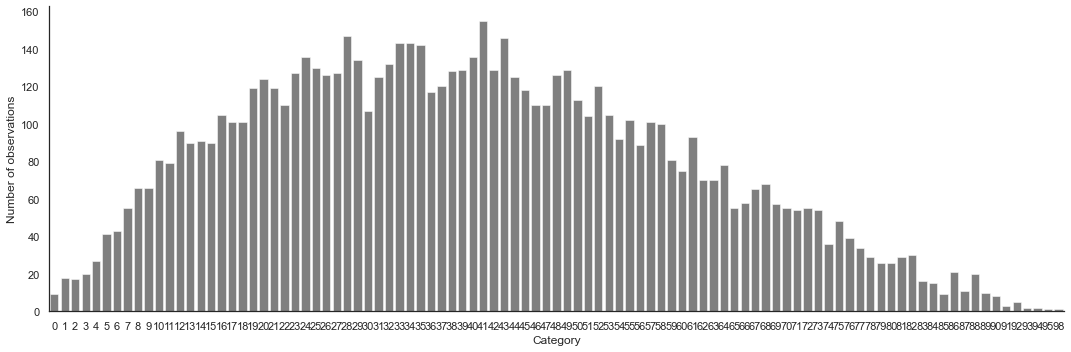

In [73]:
X_train = pd.read_csv(f"data/experiment_{exp_id}/train_data.csv")
X_test = pd.read_csv(f"data/experiment_{exp_id}/test_data.csv")
X = pd.concat([X_train, X_test], axis=0)
cat_count = X[hicard_var].value_counts()
fig = plt.figure(figsize=(15, 5))
_ = sns.barplot(x=cat_count.index, y=cat_count.values, color="black", alpha=0.5)
plt.ylabel("Number of observations")
plt.xlabel("Category")
plt.tight_layout()

In [74]:
train_scores, test_scores, plots, runtimes, fitted_models = run_sim_experiment(
    exp_id, sim_data=sim_data, y_dist="gaussian", random_state=random_seed
)

with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())
    display(pd.DataFrame(test_scores).transpose())
    display(pd.DataFrame(runtimes, index=["Runtime (sec)"]).transpose())

Restoring model weights from the end of the best epoch: 92.
Epoch 142: early stopping
79/79 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 73.
Epoch 123: early stopping


100%|██████████| 100/100 [00:03<00:00, 30.42it/s]


MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat 0.2057 0.1765 0.2571 0.2567 0.3610    0.1720   
GLM_one_hot    0.1598 0.1375 0.2027 0.2004 0.6104    0.0000   
GLM_GLMM_enc   0.1642 0.1398 0.2079 0.2054 0.5907    0.0638   
GBM_ignore_cat 0.1834 0.1575 0.2252 0.2287 0.4927    0.1606   
GBM_one_hot    0.1706 0.1466 0.2071 0.2118 0.5650    0.1345   
GBM_GLMM_enc   0.1397 0.1192 0.1763 0.1747 0.7039    0.0613   
NN_ee          0.1312 0.1116 0.1719 0.1641 0.7388    0.0271   
GBM_ee         0.1678 0.1443 0.2062 0.2096 0.5740    0.1334   
GLMM           0.1601 0.1370 0.2028 0.2006 0.6097    0.0374   
GPBoost        0.1513 0.1288 0.1961 0.1890 0.6537    0.0284   
GLMMNet        0.1314 0.1112 0.1665 0.1646 0.7374    0.0445   
GLMMNet_l2     0.1306 0.1100 0.1662 0.1629 0.7425    0.0498   

                RMSE_avg_weighted   CRPS     NLL  
GLM_ignore_cat             0.1603 0.1451  0.0590  
GLM_one_hot                0.0000 0.1131 -0.1884  
GLM_GLMM_enc               0.0244 0.1160 -0.1637  
GBM_ignore_cat             0.1518 0.1292 -0.0564  
GBM_one_hot                0.1129 0.1200 -0.1333  
GBM_GLMM_enc               0.0286 0.0986 -0.3256  
NN_ee                      0.0149 0.0925 -0.3883  
GBM_ee                     0.1164 0.1182 -0.1438  
GLMM                       0.0079 0.1132 -0.1874  
GPBoost                    0.0071 0.1068 -0.2472  
GLMMNet                    0.0219 0.0928 -0.3851  
GLMMNet_l2                 0.0274 0.0920 -0.3955

MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat 0.2057 0.1745 0.2460 0.2570 0.3748    0.1655   
GLM_one_hot    0.1651 0.1394 0.2025 0.2066 0.5959    0.0915   
GLM_GLMM_enc   0.1660 0.1410 0.2021 0.2071 0.5942    0.0823   
GBM_ignore_cat 0.1895 0.1562 0.2238 0.2396 0.4566    0.1646   
GBM_one_hot    0.1759 0.1444 0.2070 0.2217 0.5348    0.1292   
GBM_GLMM_enc   0.1493 0.1284 0.1851 0.1866 0.6703    0.0782   
NN_ee          0.1480 0.1250 0.1825 0.1858 0.6732    0.0901   
GBM_ee         0.1734 0.1421 0.2032 0.2199 0.5424    0.1370   
GLMM           0.1647 0.1399 0.2017 0.2061 0.5982    0.0780   
GPBoost        0.1654 0.1384 0.2052 0.2081 0.5900    0.0782   
GLMMNet        0.1468 0.1271 0.1821 0.1837 0.6807    0.0704   
GLMMNet_l2     0.1428 0.1248 0.1742 0.1780 0.7000    0.0687   

                RMSE_avg_weighted   CRPS     NLL  
GLM_ignore_cat             0.1608 0.1450  0.0603  
GLM_one_hot                0.0493 0.1167 -0.1579  
GLM_GLMM_enc               0.0513 0.1170 -0.1558  
GBM_ignore_cat             0.1585 0.1348 -0.0097  
GBM_one_hot                0.1183 0.1250 -0.0875  
GBM_GLMM_enc               0.0506 0.1054 -0.2596  
NN_ee                      0.0495 0.1046 -0.2640  
GBM_ee                     0.1236 0.1236 -0.0957  
GLMM                       0.0472 0.1164 -0.1604  
GPBoost                    0.0504 0.1174 -0.1411  
GLMMNet                    0.0491 0.1039 -0.2675  
GLMMNet_l2                 0.0475 0.1006 -0.3068

Runtime (sec)
GLM_ignore_cat         0.0058
GLM_one_hot            0.2948
GLM_GLMM_enc           0.0408
GBM_ignore_cat         1.4176
GBM_one_hot            2.6290
GBM_GLMM_enc           1.5919
NN_ee                 21.1447
GBM_ee                 0.2159
GLMMNet               21.5755
GLMMNet_l2           176.7839

**Observations**:
Results are mostly consistent with those from Experiment #1.
- NNs (`NN_ee`, `GLMMNet`) are clear winners whenever signal in the data is strong enough.
- Followed by `GBM_ee` and `GBM_GLMM_enc`.
    - Embeddings are transferable & provide significant benefit when the NN from which they are extracted is good.
    - GLMM encoding can perform reasonably well even under skewed distributions. Better than plain GLMM, suggesting the non-linearity in GBM is more important than getting the random effects structure 100% correct.

In [75]:
g_re = gridplot([
    plots["GLMM_encodings"], plots["GLMM_RE_pred"], 
    plots["GPBoost_RE_pred"], plots["GLMMNet_RE_pred"], 
    ], ncols=2, height=300, width=300)
bop.show(g_re)

#### Plot Ridgeline

100%|██████████| 100/100 [00:02<00:00, 35.51it/s]


79/79 [==============================] - 0s 2ms/step


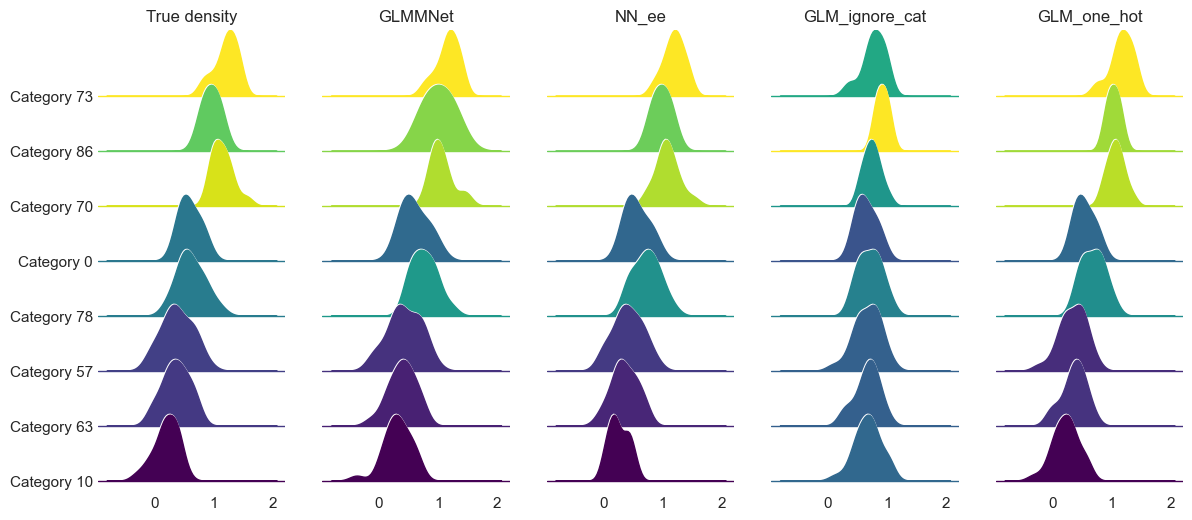

In [76]:
# To plot ridgelines, need to get the models' predictions
# Unpack data
X_train, y_train, y_true_train = sim_data["train"]
X_test, y_test, y_true_test = sim_data["test"]
Zu = sim_data["Zu"]

# Load the fitted models
X_train_ic = ignore_cat_encoder.fit_transform(X_train)
X_test_ic = ignore_cat_encoder.transform(X_test)
GLM_ignore_cat = fitted_models["GLM_ignore_cat"]

one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
X_train_ohe = one_hot_encoder.fit_transform(X_train)
X_test_ohe = one_hot_encoder.transform(X_test)
GLM_one_hot = fitted_models["GLM_one_hot"]

X_train_ct = pd.DataFrame(ct_nn.fit_transform(X_train), columns=colnames)
X_test_ct = pd.DataFrame(ct_nn.transform(X_test), columns=colnames)
X_embed_train, X_embed_test = embedding_preproc(X_train_ct, X_test_ct, [hicard_var])
NN_ee = fitted_models["NN_ee"]

one_hot = ce.OneHotEncoder(cols=[hicard_var], handle_unknown="value")
X_train_ct_ohe = one_hot.fit_transform(X_train_ct)
X_test_ct_ohe = one_hot.transform(X_test_ct)
glmmnet = fitted_models["GLMMNet"]

# To make predictions, we call the model multiple times and average the results
# This is because the random effects are sampled from the posterior (in the DenseVariational layer).
y_pred_test = predict_glmmnet(glmmnet, X_test_ct_ohe, hicard_var)

dpi = 100
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(1400/dpi, 600/dpi), dpi=dpi)

test_data = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(y_test, columns=["y"]),
    pd.DataFrame(y_true_test, columns=["y_true"])], axis=1)
ranked_cats = test_data.groupby("category").mean().sort_values("y").index.to_list()
selected_cats = ranked_cats[:3] + ranked_cats[len(ranked_cats)//2:len(ranked_cats)//2+2] + ranked_cats[-3:]
p_min, p_max = y_true_test.min(), y_true_test.max()
plot_ridgeline(X_test["category"], y_true_test, selected_cats, axes[0], "True density")
plot_ridgeline(X_test["category"], y_pred_test, selected_cats, axes[1], "GLMMNet", ylabel=False, p_min=p_min, p_max=p_max)
NN_ee_y_pred_test = NN_ee.predict((tuple(X_embed_test), X_test_ct[x_num])).flatten()
plot_ridgeline(X_test["category"], NN_ee_y_pred_test, selected_cats, axes[2], "NN_ee", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GLM_ignore_cat.predict(X_test_ic), selected_cats, axes[3], "GLM_ignore_cat", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GLM_one_hot.predict(X_test_ohe), selected_cats, axes[4], "GLM_one_hot", ylabel=False, p_min=p_min, p_max=p_max)

plt.show()
# fig.savefig(f"figures/experiment_{exp_id}/ridgeline.pdf")

### Experiment #4

In [77]:
# Configure simulation parameters
exp_id = 4                         # experiment id
sig2noise = np.array([4, 1, 2])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gaussian"                # distribution of the response variable y
inverse_link = lambda x: x         # inverse of the identity link
cat_dist = "balanced"              # distribution of the categorical variable
random_seed = 42 + exp_id          # random seed for reproducibility
log_plot = True                    # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network (entity embedding model)

In [78]:
# Generate data
sim_data = generate_data(
    exp_id=exp_id, n_train=n_train, n_test=n_test, n_categories=n_categories,
    f_structure=f_structure, signal_to_noise=sig2noise, y_dist=y_dist,
    inverse_link=inverse_link, cat_dist=cat_dist, random_state=random_seed,
    overwrite=True,
)

In [79]:
train_scores, test_scores, plots, runtimes, fitted_models = run_sim_experiment(
    exp_id, sim_data=sim_data, y_dist=y_dist, random_state=random_seed
)

with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())
    display(pd.DataFrame(test_scores).transpose())
    display(pd.DataFrame(runtimes, index=["Runtime (sec)"]).transpose())

Restoring model weights from the end of the best epoch: 24.
Epoch 74: early stopping
79/79 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 140.
Epoch 190: early stopping


100%|██████████| 100/100 [00:03<00:00, 29.17it/s]


MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat 0.2653 0.2232 0.3052 0.3329 0.2029    0.1398   
GLM_one_hot    0.2386 0.2003 0.2803 0.3013 0.3470    0.0000   
GLM_GLMM_enc   0.2445 0.2041 0.2846 0.3088 0.3141    0.0290   
GBM_ignore_cat 0.2502 0.2063 0.2908 0.3148 0.2874    0.1359   
GBM_one_hot    0.2438 0.2026 0.2811 0.3057 0.3277    0.1033   
GBM_GLMM_enc   0.2301 0.1934 0.2681 0.2897 0.3964    0.0374   
NN_ee          0.2322 0.1931 0.2751 0.2928 0.3835    0.0291   
GBM_ee         0.2442 0.2049 0.2826 0.3074 0.3204    0.1120   
GLMM           0.2388 0.2007 0.2803 0.3017 0.3454    0.0129   
GPBoost        0.2242 0.1863 0.2605 0.2838 0.4206    0.0114   
GLMMNet        0.2245 0.1911 0.2696 0.2818 0.4288    0.0284   
GLMMNet_l2     0.2308 0.1948 0.2635 0.2896 0.3967    0.0474   

                RMSE_avg_weighted   CRPS    NLL  
GLM_ignore_cat             0.1414 0.1877 0.3191  
GLM_one_hot                0.0000 0.1696 0.2193  
GLM_GLMM_enc               0.0289 0.1738 0.2439  
GBM_ignore_cat             0.1374 0.1774 0.2630  
GBM_one_hot                0.1039 0.1725 0.2339  
GBM_GLMM_enc               0.0375 0.1633 0.1800  
NN_ee                      0.0287 0.1650 0.1906  
GBM_ee                     0.1127 0.1732 0.2393  
GLMM                       0.0129 0.1699 0.2207  
GPBoost                    0.0114 0.1599 0.1596  
GLMMNet                    0.0278 0.1591 0.1540  
GLMMNet_l2                 0.0473 0.1635 0.1797

MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat 0.2623 0.2165 0.3085 0.3300 0.1976    0.1465   
GLM_one_hot    0.2427 0.2034 0.2905 0.3054 0.3127    0.0711   
GLM_GLMM_enc   0.2430 0.2050 0.2867 0.3055 0.3123    0.0718   
GBM_ignore_cat 0.2550 0.2150 0.2934 0.3203 0.2437    0.1450   
GBM_one_hot    0.2477 0.2073 0.2892 0.3107 0.2886    0.1113   
GBM_GLMM_enc   0.2366 0.1976 0.2736 0.2967 0.3514    0.0755   
NN_ee          0.2387 0.1981 0.2873 0.3008 0.3333    0.0762   
GBM_ee         0.2509 0.2114 0.2893 0.3149 0.2690    0.1275   
GLMM           0.2425 0.2034 0.2872 0.3053 0.3130    0.0702   
GPBoost        0.2405 0.2038 0.2875 0.3019 0.3283    0.0693   
GLMMNet        0.2368 0.1959 0.2871 0.2979 0.3458    0.0760   
GLMMNet_l2     0.2335 0.1951 0.2726 0.2942 0.3620    0.0812   

                RMSE_avg_weighted   CRPS    NLL  
GLM_ignore_cat             0.1439 0.1856 0.3102  
GLM_one_hot                0.0713 0.1722 0.2328  
GLM_GLMM_enc               0.0719 0.1722 0.2331  
GBM_ignore_cat             0.1421 0.1805 0.2806  
GBM_one_hot                0.1112 0.1753 0.2500  
GBM_GLMM_enc               0.0756 0.1674 0.2038  
NN_ee                      0.0760 0.1694 0.2176  
GBM_ee                     0.1251 0.1776 0.2636  
GLMM                       0.0703 0.1721 0.2326  
GPBoost                    0.0696 0.1706 0.2243  
GLMMNet                    0.0759 0.1683 0.2179  
GLMMNet_l2                 0.0803 0.1659 0.1955

Runtime (sec)
GLM_ignore_cat         0.0057
GLM_one_hot            0.1536
GLM_GLMM_enc           0.1282
GBM_ignore_cat         1.1700
GBM_one_hot            0.3557
GBM_GLMM_enc           0.1591
NN_ee                 11.1851
GBM_ee                 0.1894
GLMMNet               34.5232
GLMMNet_l2           178.8801

In [80]:
# Redo prediction plots
# bop.show(plots["GBM_one_hot"])
# bop.show(plots["GLMM"])
# bop.show(plots["NN_ee"])
bop.show(plots["GLMMNet_l2"])

In [81]:
g_re = gridplot([
    plots["GLMM_encodings"], plots["GLMM_RE_pred"], 
    plots["GLMMNet_RE_pred"], plots["GLMMNet_l2_RE_pred"],
    ], ncols=2, height=300, width=300)
bop.show(g_re)

#### Plot Ridgeline

100%|██████████| 100/100 [00:02<00:00, 34.10it/s]


79/79 [==============================] - 0s 3ms/step


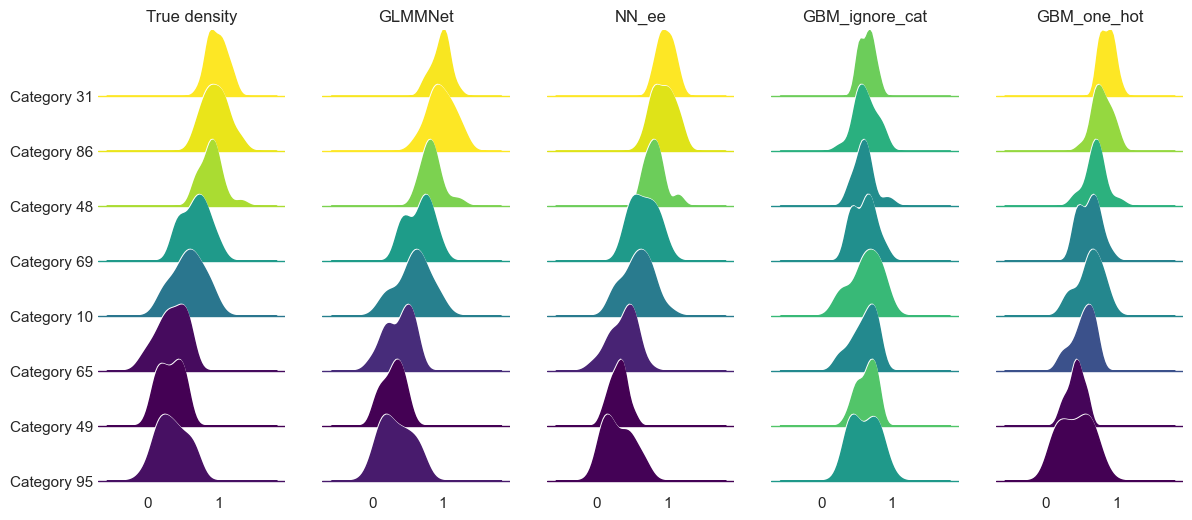

In [82]:
# To plot ridgelines, need to get the models' predictions
# Unpack data
X_train, y_train, y_true_train = sim_data["train"]
X_test, y_test, y_true_test = sim_data["test"]
Zu = sim_data["Zu"]

ignore_cat_encoder = make_column_transformer(
    ("drop", [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
X_train_ic = ignore_cat_encoder.fit_transform(X_train)
X_test_ic = ignore_cat_encoder.transform(X_test)

one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
X_train_ohe = one_hot_encoder.fit_transform(X_train)
X_test_ohe = one_hot_encoder.transform(X_test)

ct_nn = make_column_transformer(
    (ce.ordinal.OrdinalEncoder(handle_unknown="value"), [hicard_var]), # "value" encodes unknown categories as "-1"
    (MinMaxScaler(feature_range=(0, 1)), x_num),
)
X_train_ct = pd.DataFrame(ct_nn.fit_transform(X_train), columns=colnames)
X_test_ct = pd.DataFrame(ct_nn.transform(X_test), columns=colnames)
X_embed_train, X_embed_test = embedding_preproc(X_train_ct, X_test_ct, [hicard_var])

one_hot = ce.OneHotEncoder(cols=[hicard_var], handle_unknown="value")
X_train_ct_ohe = one_hot.fit_transform(X_train_ct)
X_test_ct_ohe = one_hot.transform(X_test_ct)

# Get the fitted models
NN_ee = fitted_models["NN_ee"]
glmmnet = fitted_models["GLMMNet"]
GBM_one_hot = fitted_models["GBM_one_hot"]
GBM_ignore_cat = fitted_models["GBM_ignore_cat"]

# To make predictions, we call the model multiple times and average the results
# This is because the random effects are sampled from the posterior (in the DenseVariational layer).
y_pred_test = predict_glmmnet(glmmnet, X_test_ct_ohe, hicard_var)

dpi = 100
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(1400/dpi, 600/dpi), dpi=dpi)
test_data = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(y_test, columns=["y"]),
    pd.DataFrame(y_true_test, columns=["y_true"])], axis=1)
ranked_cats = test_data.groupby("category").mean().sort_values("y").index.to_list()
selected_cats = ranked_cats[:3] + ranked_cats[len(ranked_cats)//2:len(ranked_cats)//2+2] + ranked_cats[-3:]
p_min, p_max = y_true_test.min(), y_true_test.max()
plot_ridgeline(X_test["category"], y_true_test, selected_cats, axes[0], "True density")
plot_ridgeline(X_test["category"], y_pred_test, selected_cats, axes[1], "GLMMNet", ylabel=False, p_min=p_min, p_max=p_max)
NN_ee_y_pred_test = NN_ee.predict((tuple(X_embed_test), X_test_ct[x_num])).flatten()
plot_ridgeline(X_test["category"], NN_ee_y_pred_test, selected_cats, axes[2], "NN_ee", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GBM_ignore_cat.predict(X_test_ic), selected_cats, axes[3], "GBM_ignore_cat", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GBM_one_hot.predict(X_test_ohe), selected_cats, axes[4], "GBM_one_hot", ylabel=False, p_min=p_min, p_max=p_max)

plt.show()
# fig.savefig(f"figures/experiment_{exp_id}/ridgeline.pdf")

### Experiment #5

**Observations**:
- More typical of what we see with real insurance data. Differences in performance are small.
- As often observed in practice with tabular data, GBM shows a marginal but consistent advantage over GLM and NN.
- Models with random effects (including GLMM encoded models) can capture the between-category differences better than the entity embeddings.

RE predictions are much worse compared to experiment #1 (as one would expect, the models would have picked up more random noise).

In [83]:
# Configure simulation parameters
exp_id = 5                         # experiment id
sig2noise = np.array([8, 1, 4])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gaussian"                # distribution of the response variable y
inverse_link = lambda x: x         # inverse of the log link
cat_dist = "balanced"              # distribution of the categorical variable
random_seed = 42 + exp_id          # random seed for reproducibility
log_plot = True                    # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network (entity embedding model)

In [84]:
# Generate data
sim_data = generate_data(
    exp_id=exp_id, n_train=n_train, n_test=n_test, n_categories=n_categories,
    f_structure=f_structure, signal_to_noise=sig2noise, y_dist=y_dist,
    inverse_link=inverse_link, cat_dist=cat_dist, random_state=random_seed,
    overwrite=True,
)

In [85]:
train_scores, test_scores, plots, runtimes, fitted_models = run_sim_experiment(
    exp_id, sim_data=sim_data, y_dist=y_dist, random_state=random_seed
)

with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())
    display(pd.DataFrame(test_scores).transpose())
    display(pd.DataFrame(runtimes, index=["Runtime (sec)"]).transpose())

Restoring model weights from the end of the best epoch: 47.
Epoch 97: early stopping
79/79 [==============================] - 0s 3ms/step
Restoring model weights from the end of the best epoch: 83.
Epoch 133: early stopping


100%|██████████| 100/100 [00:03<00:00, 31.77it/s]


MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat 0.2632 0.2248 0.3017 0.3303 0.2300    0.0762   
GLM_one_hot    0.2565 0.2199 0.2963 0.3215 0.2705    0.0000   
GLM_GLMM_enc   0.2613 0.2241 0.2997 0.3279 0.2412    0.0433   
GBM_ignore_cat 0.2470 0.2105 0.2832 0.3089 0.3267    0.0721   
GBM_one_hot    0.2462 0.2099 0.2835 0.3080 0.3308    0.0621   
GBM_GLMM_enc   0.2447 0.2067 0.2873 0.3064 0.3377    0.0475   
NN_ee          0.2429 0.2063 0.2819 0.3032 0.3513    0.0263   
GBM_ee         0.2456 0.2076 0.2835 0.3075 0.3326    0.0642   
GLMM           0.2574 0.2209 0.2953 0.3226 0.2656    0.0284   
GPBoost        0.2426 0.2092 0.2862 0.3036 0.3494    0.0270   
GLMMNet        0.2383 0.1996 0.2804 0.2991 0.3689    0.0250   
GLMMNet_l2     0.2431 0.2061 0.2848 0.3047 0.3450    0.0353   

                RMSE_avg_weighted   CRPS    NLL  
GLM_ignore_cat             0.0756 0.1863 0.3113  
GLM_one_hot                0.0000 0.1814 0.2843  
GLM_GLMM_enc               0.0425 0.1850 0.3040  
GBM_ignore_cat             0.0713 0.1744 0.2442  
GBM_one_hot                0.0613 0.1738 0.2412  
GBM_GLMM_enc               0.0464 0.1729 0.2360  
NN_ee                      0.0253 0.1711 0.2256  
GBM_ee                     0.0633 0.1735 0.2398  
GLMM                       0.0278 0.1820 0.2877  
GPBoost                    0.0263 0.1714 0.2271  
GLMMNet                    0.0251 0.1687 0.2152  
GLMMNet_l2                 0.0353 0.1719 0.2304

MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat 0.2644 0.2237 0.3041 0.3313 0.2220    0.1016   
GLM_one_hot    0.2605 0.2231 0.2977 0.3256 0.2486    0.0798   
GLM_GLMM_enc   0.2603 0.2184 0.2977 0.3255 0.2491    0.0797   
GBM_ignore_cat 0.2545 0.2150 0.2902 0.3203 0.2730    0.0982   
GBM_one_hot    0.2531 0.2137 0.2873 0.3186 0.2804    0.0920   
GBM_GLMM_enc   0.2510 0.2104 0.2834 0.3158 0.2931    0.0817   
NN_ee          0.2572 0.2207 0.2946 0.3213 0.2683    0.0866   
GBM_ee         0.2540 0.2155 0.2883 0.3195 0.2765    0.0951   
GLMM           0.2603 0.2200 0.2989 0.3257 0.2483    0.0805   
GPBoost        0.2560 0.2130 0.2886 0.3215 0.2673    0.0788   
GLMMNet        0.2583 0.2142 0.2948 0.3232 0.2594    0.0878   
GLMMNet_l2     0.2521 0.2138 0.2838 0.3171 0.2874    0.0890   

                RMSE_avg_weighted   CRPS    NLL  
GLM_ignore_cat             0.0999 0.1868 0.3142  
GLM_one_hot                0.0789 0.1839 0.2968  
GLM_GLMM_enc               0.0785 0.1838 0.2965  
GBM_ignore_cat             0.0968 0.1805 0.2803  
GBM_one_hot                0.0902 0.1795 0.2752  
GBM_GLMM_enc               0.0803 0.1781 0.2663  
NN_ee                      0.0853 0.1815 0.2835  
GBM_ee                     0.0936 0.1800 0.2779  
GLMM                       0.0791 0.1838 0.2970  
GPBoost                    0.0773 0.1815 0.2870  
GLMMNet                    0.0867 0.1832 0.3096  
GLMMNet_l2                 0.0876 0.1790 0.2703

Runtime (sec)
GLM_ignore_cat         0.0106
GLM_one_hot            0.3078
GLM_GLMM_enc           0.1687
GBM_ignore_cat         0.5576
GBM_one_hot            0.2197
GBM_GLMM_enc           0.1781
NN_ee                 15.6401
GBM_ee                 0.2109
GLMMNet               25.0389
GLMMNet_l2           190.0402

100%|██████████| 100/100 [00:03<00:00, 32.76it/s]


79/79 [==============================] - 0s 2ms/step


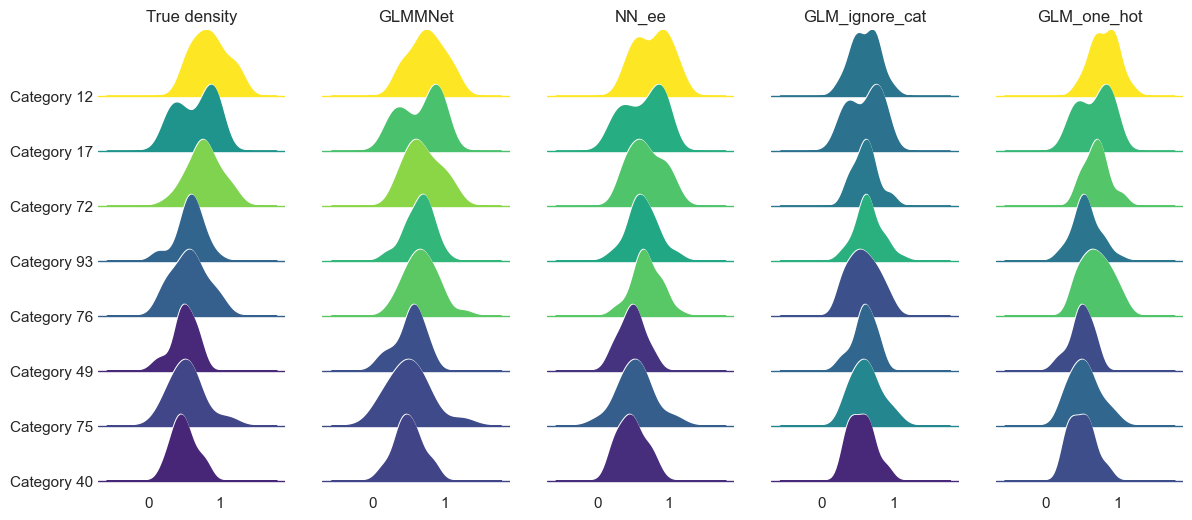

In [86]:
# To plot ridgelines, need to get the models' predictions
# Unpack data
X_train, y_train, y_true_train = sim_data["train"]
X_test, y_test, y_true_test = sim_data["test"]
Zu = sim_data["Zu"]

# Refit models
X_train_ic = ignore_cat_encoder.fit_transform(X_train)
X_test_ic = ignore_cat_encoder.transform(X_test)
GLM_ignore_cat = fitted_models["GLM_ignore_cat"]

one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
X_train_ohe = one_hot_encoder.fit_transform(X_train)
X_test_ohe = one_hot_encoder.transform(X_test)
GLM_one_hot = fitted_models["GLM_one_hot"]

X_train_ct = pd.DataFrame(ct_nn.fit_transform(X_train), columns=colnames)
X_test_ct = pd.DataFrame(ct_nn.transform(X_test), columns=colnames)
X_embed_train, X_embed_test = embedding_preproc(X_train_ct, X_test_ct, [hicard_var])
NN_ee = fitted_models["NN_ee"]

one_hot = ce.OneHotEncoder(cols=[hicard_var], handle_unknown="value")
X_train_ct_ohe = one_hot.fit_transform(X_train_ct)
X_test_ct_ohe = one_hot.transform(X_test_ct)
glmmnet = fitted_models["GLMMNet"]

# To make predictions, we call the model multiple times and average the results
# This is because the random effects are sampled from the posterior (in the DenseVariational layer).
y_pred_test = predict_glmmnet(glmmnet, X_test_ct_ohe, hicard_var)

dpi = 100
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(1400/dpi, 600/dpi), dpi=dpi)

test_data = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(y_test, columns=["y"]),
    pd.DataFrame(y_true_test, columns=["y_true"])], axis=1)
ranked_cats = test_data.groupby("category").mean().sort_values("y").index.to_list()
selected_cats = ranked_cats[:3] + ranked_cats[len(ranked_cats)//2:len(ranked_cats)//2+2] + ranked_cats[-3:]
p_min, p_max = y_true_test.min(), y_true_test.max()
plot_ridgeline(X_test["category"], y_true_test, selected_cats, axes[0], "True density")
plot_ridgeline(X_test["category"], y_pred_test, selected_cats, axes[1], "GLMMNet", ylabel=False, p_min=p_min, p_max=p_max)
NN_ee_y_pred_test = NN_ee.predict((tuple(X_embed_test), X_test_ct[x_num])).flatten()
plot_ridgeline(X_test["category"], NN_ee_y_pred_test, selected_cats, axes[2], "NN_ee", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GLM_ignore_cat.predict(X_test_ic), selected_cats, axes[3], "GLM_ignore_cat", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GLM_one_hot.predict(X_test_ohe), selected_cats, axes[4], "GLM_one_hot", ylabel=False, p_min=p_min, p_max=p_max)

plt.show()
# fig.savefig(f"figures/experiment_{exp_id}/ridgeline.pdf")

In [87]:
g_re = gridplot([
    plots["GLMM_encodings"], plots["GLMM_RE_pred"], 
    plots["GLMMNet_RE_pred"], plots["GLMMNet_l2_RE_pred"],
    ], ncols=2, height=300, width=300)
bop.show(g_re)

### Experiment #6

In [88]:
# Configure simulation parameters
exp_id = 6                         # experiment id
sig2noise = np.array([8, 1, 4])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gamma"                   # distribution of the response variable y
inverse_link = np.exp              # inverse of the log link
cat_dist = "skewed"                # distribution of the categorical variable
random_seed = 42 + exp_id          # random seed for reproducibility
log_plot = True                    # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network (entity embedding model)

In [89]:
# Generate data
sim_data = generate_data(
    exp_id=exp_id, n_train=n_train,  n_test=n_test, n_categories=n_categories,
    f_structure=f_structure, signal_to_noise=sig2noise, y_dist=y_dist,
    inverse_link=inverse_link, cat_dist=cat_dist, random_state=random_seed,
    overwrite=True,
)

In [90]:
print("Please pause and run R script to generate the results required.")
print("Remember to update the parameters in the R script to match the current settings.")

Please pause and run R script to generate the results required.
Remember to update the parameters in the R script to match the current settings.


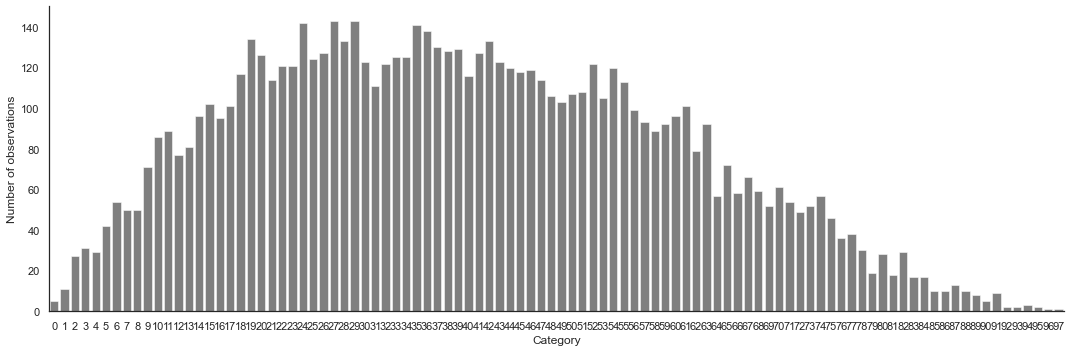

In [91]:
X_train = pd.read_csv(f"data/experiment_{exp_id}/train_data.csv")
X_test = pd.read_csv(f"data/experiment_{exp_id}/test_data.csv")
X = pd.concat([X_train, X_test], axis=0)
cat_count = X[hicard_var].value_counts()
fig = plt.figure(figsize=(15, 5))
_ = sns.barplot(x=cat_count.index, y=cat_count.values, color="black", alpha=0.5)
plt.ylabel("Number of observations")
plt.xlabel("Category")
plt.tight_layout()

In [92]:
# Not the best practice..
# but there seems no other way to suppress warnings around unknown categories being transformed to all zeros,
# even though they have been told to handle_unknown="ignore"
import warnings
warnings.simplefilter("ignore", UserWarning)

In [93]:
train_scores, test_scores, plots, runtimes, fitted_models = run_sim_experiment(
    exp_id, sim_data=sim_data, y_dist=y_dist, random_state=random_seed
)

with pd.option_context("display.float_format", "{:.4f}".format):
    display(pd.DataFrame(train_scores).transpose())
    display(pd.DataFrame(test_scores).transpose())
    display(pd.DataFrame(runtimes, index=["Runtime (sec)"]).transpose())

Restoring model weights from the end of the best epoch: 56.
Epoch 106: early stopping
79/79 [==============================] - 0s 2ms/step
Restoring model weights from the end of the best epoch: 40.
Epoch 90: early stopping


100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat 0.5104 0.4116 0.2251 0.6674 0.2082    0.2423   
GLM_one_hot    0.4893 0.3917 0.2142 0.6388 0.2745    0.0663   
GLM_GLMM_enc   0.4988 0.3997 0.2196 0.6510 0.2467    0.1706   
GBM_ignore_cat 0.4747 0.3836 0.2088 0.6212 0.3139    0.2302   
GBM_one_hot    0.4729 0.3879 0.2071 0.6179 0.3212    0.2108   
GBM_GLMM_enc   0.4635 0.3777 0.2033 0.6049 0.3496    0.1659   
NN_ee          0.4668 0.3707 0.2064 0.6085 0.3419    0.0760   
GBM_ee         0.4715 0.3847 0.2075 0.6169 0.3235    0.2101   
GLMM           0.4909 0.3912 0.2159 0.6409 0.2699    0.1442   
GPBoost        0.4871 0.3960 0.2146 0.6380 0.2763    0.2301   
GLMMNet        0.4671 0.3775 0.2033 0.6083 0.3423    0.1413   
GLMMNet_l2     0.4607 0.3668 0.2039 0.6025 0.3546    0.1488   

                RMSE_avg_weighted   CRPS    NLL  
GLM_ignore_cat             0.1890 0.3612 0.9257  
GLM_one_hot                0.0200 0.3456 0.8815  
GLM_GLMM_enc               0.0760 0.3525 0.9007  
GBM_ignore_cat             0.1830 0.3361 0.8547  
GBM_one_hot                0.1480 0.3343 0.8490  
GBM_GLMM_enc               0.0836 0.3274 0.8286  
NN_ee                      0.0508 0.3295 0.8354  
GBM_ee                     0.1515 0.3336 0.8468  
GLMM                       0.0521 0.3468 0.8847  
GPBoost                    0.1809 0.3454 0.8827  
GLMMNet                    0.0663 0.3291 0.8327  
GLMMNet_l2                 0.0819 0.3264 0.8264

MAE  MedAE  MedPE   RMSE     R2  RMSE_avg  \
GLM_ignore_cat 0.5243 0.4241 0.2405 0.6858 0.2143    0.3081   
GLM_one_hot    0.5081 0.4088 0.2264 0.6649 0.2616    0.2602   
GLM_GLMM_enc   0.5106 0.4068 0.2277 0.6669 0.2571    0.2619   
GBM_ignore_cat 0.5067 0.4135 0.2254 0.6640 0.2634    0.3051   
GBM_one_hot    0.5038 0.4111 0.2248 0.6598 0.2729    0.2927   
GBM_GLMM_enc   0.4938 0.4018 0.2213 0.6458 0.3034    0.2616   
NN_ee          0.4956 0.3942 0.2204 0.6467 0.3013    0.2444   
GBM_ee         0.5017 0.4086 0.2228 0.6581 0.2767    0.2906   
GLMM           0.5080 0.4097 0.2268 0.6645 0.2624    0.2644   
GPBoost        0.5060 0.4123 0.2256 0.6636 0.2644    0.2996   
GLMMNet        0.4972 0.3926 0.2176 0.6495 0.2954    0.2575   
GLMMNet_l2     0.4815 0.3861 0.2150 0.6315 0.3338    0.2594   

                RMSE_avg_weighted   CRPS    NLL  
GLM_ignore_cat             0.2366 0.3687 0.9381  
GLM_one_hot                0.1753 0.3578 0.9125  
GLM_GLMM_enc               0.1826 0.3588 0.9135  
GBM_ignore_cat             0.2369 0.3570 0.9082  
GBM_one_hot                0.2152 0.3545 0.9017  
GBM_GLMM_enc               0.1781 0.3472 0.8821  
NN_ee                      0.1760 0.3486 0.8884  
GBM_ee                     0.2165 0.3536 0.8988  
GLMM                       0.1735 0.3575 0.9109  
GPBoost                    0.2312 0.3568 0.9080  
GLMMNet                    0.1731 0.3505 0.8975  
GLMMNet_l2                 0.1687 0.3399 0.8618

Runtime (sec)
GLM_ignore_cat         0.2277
GLM_one_hot            1.2250
GLM_GLMM_enc           0.0313
GBM_ignore_cat         0.6244
GBM_one_hot            0.3263
GBM_GLMM_enc           0.1523
NN_ee                 16.6874
GBM_ee                 0.2113
GLMMNet               20.8994
GLMMNet_l2           202.7462

In [94]:
g_re = gridplot([
    plots["GLMM_encodings"], plots["GLMM_RE_pred"], 
    plots["GLMMNet_RE_pred"], plots["GLMMNet_l2_RE_pred"]
    ], ncols=2, height=300, width=300)
bop.show(g_re)

100%|██████████| 1000/1000 [00:38<00:00, 25.93it/s]


79/79 [==============================] - 0s 3ms/step


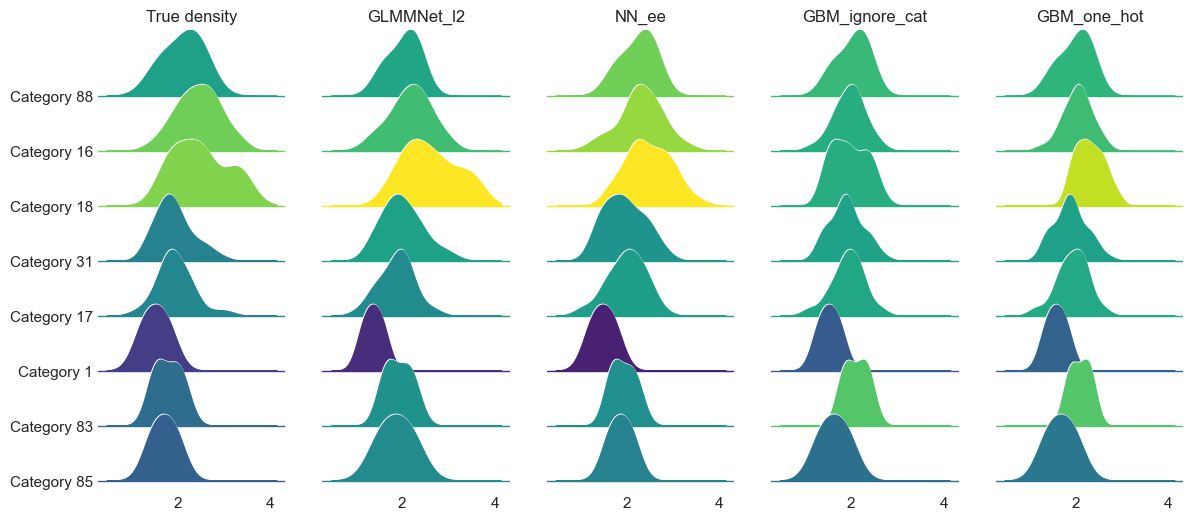

In [95]:
# To plot ridgelines, need to get the models' predictions
# Unpack data
X_train, y_train, y_true_train = sim_data["train"]
X_test, y_test, y_true_test = sim_data["test"]
Zu = sim_data["Zu"]

ignore_cat_encoder = make_column_transformer(
    ("drop", [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
X_train_ic = ignore_cat_encoder.fit_transform(X_train)
X_test_ic = ignore_cat_encoder.transform(X_test)

one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
X_train_ohe = one_hot_encoder.fit_transform(X_train)
X_test_ohe = one_hot_encoder.transform(X_test)

ct_nn = make_column_transformer(
    (ce.ordinal.OrdinalEncoder(handle_unknown="value"), [hicard_var]), # "value" encodes unknown categories as "-1"
    (MinMaxScaler(feature_range=(0, 1)), x_num),
)
X_train_ct = pd.DataFrame(ct_nn.fit_transform(X_train), columns=colnames)
X_test_ct = pd.DataFrame(ct_nn.transform(X_test), columns=colnames)
X_embed_train, X_embed_test = embedding_preproc(X_train_ct, X_test_ct, [hicard_var])

one_hot = ce.OneHotEncoder(cols=[hicard_var], handle_unknown="value")
X_train_ct_ohe = one_hot.fit_transform(X_train_ct)
X_test_ct_ohe = one_hot.transform(X_test_ct)

# Get the fitted models
NN_ee = fitted_models["NN_ee"]
glmmnet = fitted_models["GLMMNet"]
glmmnet_l2 = fitted_models["GLMMNet_l2"]
GBM_one_hot = fitted_models["GBM_one_hot"]
GBM_ignore_cat = fitted_models["GBM_ignore_cat"]

# To make predictions, we call the model multiple times and average the results
# This is because the random effects are sampled from the posterior (in the DenseVariational layer).
n_prediction_samples = 1000
y_pred_test = predict_glmmnet(glmmnet_l2, X_test_ct_ohe, hicard_var, n_prediction_samples)

dpi = 100
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(1400/dpi, 600/dpi), dpi=dpi)
test_data = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(y_test, columns=["y"]),
    pd.DataFrame(y_true_test, columns=["y_true"])], axis=1)
ranked_cats = test_data.groupby("category").mean().sort_values("y").index.to_list()
ranked_cats_by_freq = test_data.groupby("category").size().sort_values(ascending=False).index.to_list()
more_than_1_obs = test_data.groupby("category").count().query("y > 1").index.to_list()
ranked_cats = [cat for cat in ranked_cats if cat in more_than_1_obs]
ranked_cats_by_freq = [cat for cat in ranked_cats_by_freq if cat in more_than_1_obs]
selected_cats = ranked_cats[:3] + ranked_cats[len(ranked_cats)//2:len(ranked_cats)//2+2] + ranked_cats[-3:]
# selected_cats = ranked_cats_by_freq[:3] + ranked_cats_by_freq[len(ranked_cats_by_freq)//2:len(ranked_cats_by_freq)//2+2] + ranked_cats_by_freq[-3:]
# selected_cats = ranked_cats_by_freq[:4] + ranked_cats_by_freq[-4:]
p_min, p_max = y_true_test.min(), y_true_test.max()
plot_ridgeline(X_test["category"], y_true_test, selected_cats, axes[0], "True density")
plot_ridgeline(X_test["category"], y_pred_test, selected_cats, axes[1], "GLMMNet_l2", ylabel=False, p_min=p_min, p_max=p_max)
NN_ee_y_pred_test = NN_ee.predict((tuple(X_embed_test), X_test_ct[x_num])).flatten()
plot_ridgeline(X_test["category"], NN_ee_y_pred_test, selected_cats, axes[2], "NN_ee", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GBM_ignore_cat.predict(X_test_ic), selected_cats, axes[3], "GBM_ignore_cat", ylabel=False, p_min=p_min, p_max=p_max)
plot_ridgeline(X_test["category"], GBM_one_hot.predict(X_test_ohe), selected_cats, axes[4], "GBM_one_hot", ylabel=False, p_min=p_min, p_max=p_max)

plt.show()
# fig.savefig(f"figures/experiment_{exp_id}/ridgeline.pdf")